In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from arch.unitroot import VarianceRatio
from itertools import groupby
from scipy.stats import norm
from sklearn.metrics import r2_score
from statsmodels.robust.scale import mad

from sgmbasketball.models.factor_model.play_by_play_data import PlayByPlayCleanData
from stratagemdataprocessing.data_api import find_basketball_events

from sgmresearchbase.coint.space import normalise
from sgmresearchbase.coint.common import hurst_naive
from sgmresearchbase.coint.services import CointegrationService, _zs
from sgmresearchbase.coint.projection import interpolate

from IPython.display import clear_output

In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 6)

In [5]:
START_DT = datetime.datetime(2016, 10, 1)
END_DT = datetime.datetime(2017, 6, 1)

ALL_EVENTS = find_basketball_events(START_DT, END_DT, True)
NBA_EVENTS = filter(lambda e: e['stage_name'] == 'NBA', ALL_EVENTS)

PBP = PlayByPlayCleanData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', 'pbp', fixture_filter=None).get_data_ready()
clear_output()

In [6]:
def get_basis(vals, model=1):
    if vals.shape[0] < 1:
        return np.zeros((2,))

    both_bases = CointegrationService.get_cointegrating_bases(vals, model=model)
    if both_bases is None:
        return np.zeros((2,))

    if both_bases[0, 0]*both_bases[1, 0] < 0:
        basis = both_bases[:, 0]
    elif both_bases[0, 1]*both_bases[1, 1] < 0:
        basis = both_bases[:, 1]
    else:
        basis = both_bases[:, 0]*0.0    

    if basis[0] < 0:
        basis = -basis

    return basis

In [7]:
def z_based_outlier(points, thresh=3.0):
    mean = np.mean(points, axis=0)
    diff = points - mean

    return np.abs(diff / np.std(points)) > thresh

def mad_based_outlier(points, thresh=3.5):
    median = np.median(points, axis=0)
    diff = points - median
    med_abs_deviation = np.median(np.abs(diff))

    return np.abs(0.6745 * diff / med_abs_deviation) > thresh

In [8]:
def smoothed_bases(bases):
    def get_valid(idx):
        return bases[:(idx+1)][~z_based_outlier(bases[:(idx+1), 0])]

    return np.array(
        [(np.median(get_valid(i), axis=0)) for i in range(bases.shape[0])]
    )

In [1]:
def compare_betas(b1, b2):
    signs = np.sign(b1)
    if (signs == -np.sign(b2)).all():
        diff = b1 - np.abs(b2)*signs
    else:
        diff = b1 - b2

    return np.linalg.norm(diff)

In [10]:
def plot_scores(scores, ax):
    ax.plot(scores)
    ax.legend(['Team 1', 'Team 2'], loc='best')
    ax.set_ylabel('Score [-]')
    ax.set_xlabel('Event [-]')

In [11]:
def plot_bases(bases, actual_basis, ax):
    ax.plot(bases, drawstyle='steps-post')
    ax.axhline(actual_basis[0], color='k')
    ax.axhline(actual_basis[1], color='k')
    ax.set_xlabel('Event [-]')
    ax.set_ylabel('Basis value [-]')

In [12]:
def plot_residuals(bases, actual_basis, ax):
    ax.scatter(np.arange(bases.shape[0]), (bases - actual_basis)[:, 0])
    ax.set_xlabel('Event [-]')
    ax.set_ylabel('Residual $\\beta_0 - \\tilde{\\beta_0}$ [-]')

In [13]:
def plot_errors(bases, actual_basis, ax, n_phases=4):
    for g in np.array_split([b for b in bases[:] if np.sum(np.abs(b)) > 1e-7], n_phases):
        sns.distplot([compare_betas(actual_basis, b) for b in g], ax=ax)

    ax.legend(['Phase %d' % i for i in range(n_phases)], loc='best')
    ax.set_ylabel('Frequency [-]')
    ax.set_xlabel('Estimate error norm [-]')

In [14]:
def plot_dists(bases, ax):
    sns.distplot([b for b in bases[:, 0] if abs(b) > 0.0], ax=ax)
    sns.distplot([b for b in bases[:, 1] if abs(b) > 0.0], ax=ax)
    ax.set_ylabel('Frequency [-]')
    ax.set_xlabel('basis value [-]')

In [15]:
def do_basis_plots(bases, actual_basis, axes):
    plot_bases(bases, actual_basis, axes[0])
    plot_residuals(bases, actual_basis, axes[1])
    plot_errors(bases, actual_basis, axes[2])
    plot_dists(bases, axes[3])

In [16]:
from sgmbasketball.models.factor_model.raw_data import NaturalHandicapRawData
NH = NaturalHandicapRawData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', '', fixture_filter=None, use_cache=False).get_data_ready()

def get_nh(eid):
    return NH.loc[eid, 'ftps_1_line']

def nh_prior(nh):
    p = 0.5 + 0.002*nh
    return np.array([p, p-1])

In [17]:
def do_analysis(eid, lb=100):
    data = PBP.loc[eid]
    X = data[['points_h', 'points_a']].values
    prior = nh_prior(get_nh(eid))

    actual_basis = get_basis(X)
    bases_windowed = np.array([prior]*lb + [get_basis(X[(i-lb):i, :]) for i in range(lb, X.shape[0])])
    bases_agg = np.array([prior]*lb + [get_basis(X[:i, :]) for i in range(lb, X.shape[0])])
#     bases_filtered = smoothed_bases(bases_agg)

    print 'First half: ', get_basis(data.loc[['Q1', 'Q2']][['points_h', 'points_a']].values)
    print 'Second half:', get_basis(data.loc[['Q3', 'Q4']][['points_h', 'points_a']].values)
    print 'Full match: ', actual_basis

    f = plt.figure(figsize=(16, 18))

    ax = plt.subplot2grid((5, 2), (0, 0), colspan=2)
    ax.set_title('Event ID: %d' % eid)
    plot_scores(X, ax)

    plt.subplot2grid((5, 2), (1, 0))
    axes = [plt.subplot2grid((5, 2), (i, 0)) for i in range(1, 5)]
    axes[0].set_title('Aggregate (filtered)')
    do_basis_plots(bases_agg, actual_basis, axes)

    axes = [plt.subplot2grid((5, 2), (i, 1)) for i in range(1, 5)]
    axes[0].set_title('Windowed (100)')
    do_basis_plots(bases_windowed, actual_basis, axes)

    plt.tight_layout()

First half:  [ 0.45573793 -0.54426207]
Second half: [ 0.52211256 -0.47788744]
Full match:  [ 0.4815972 -0.5184028]


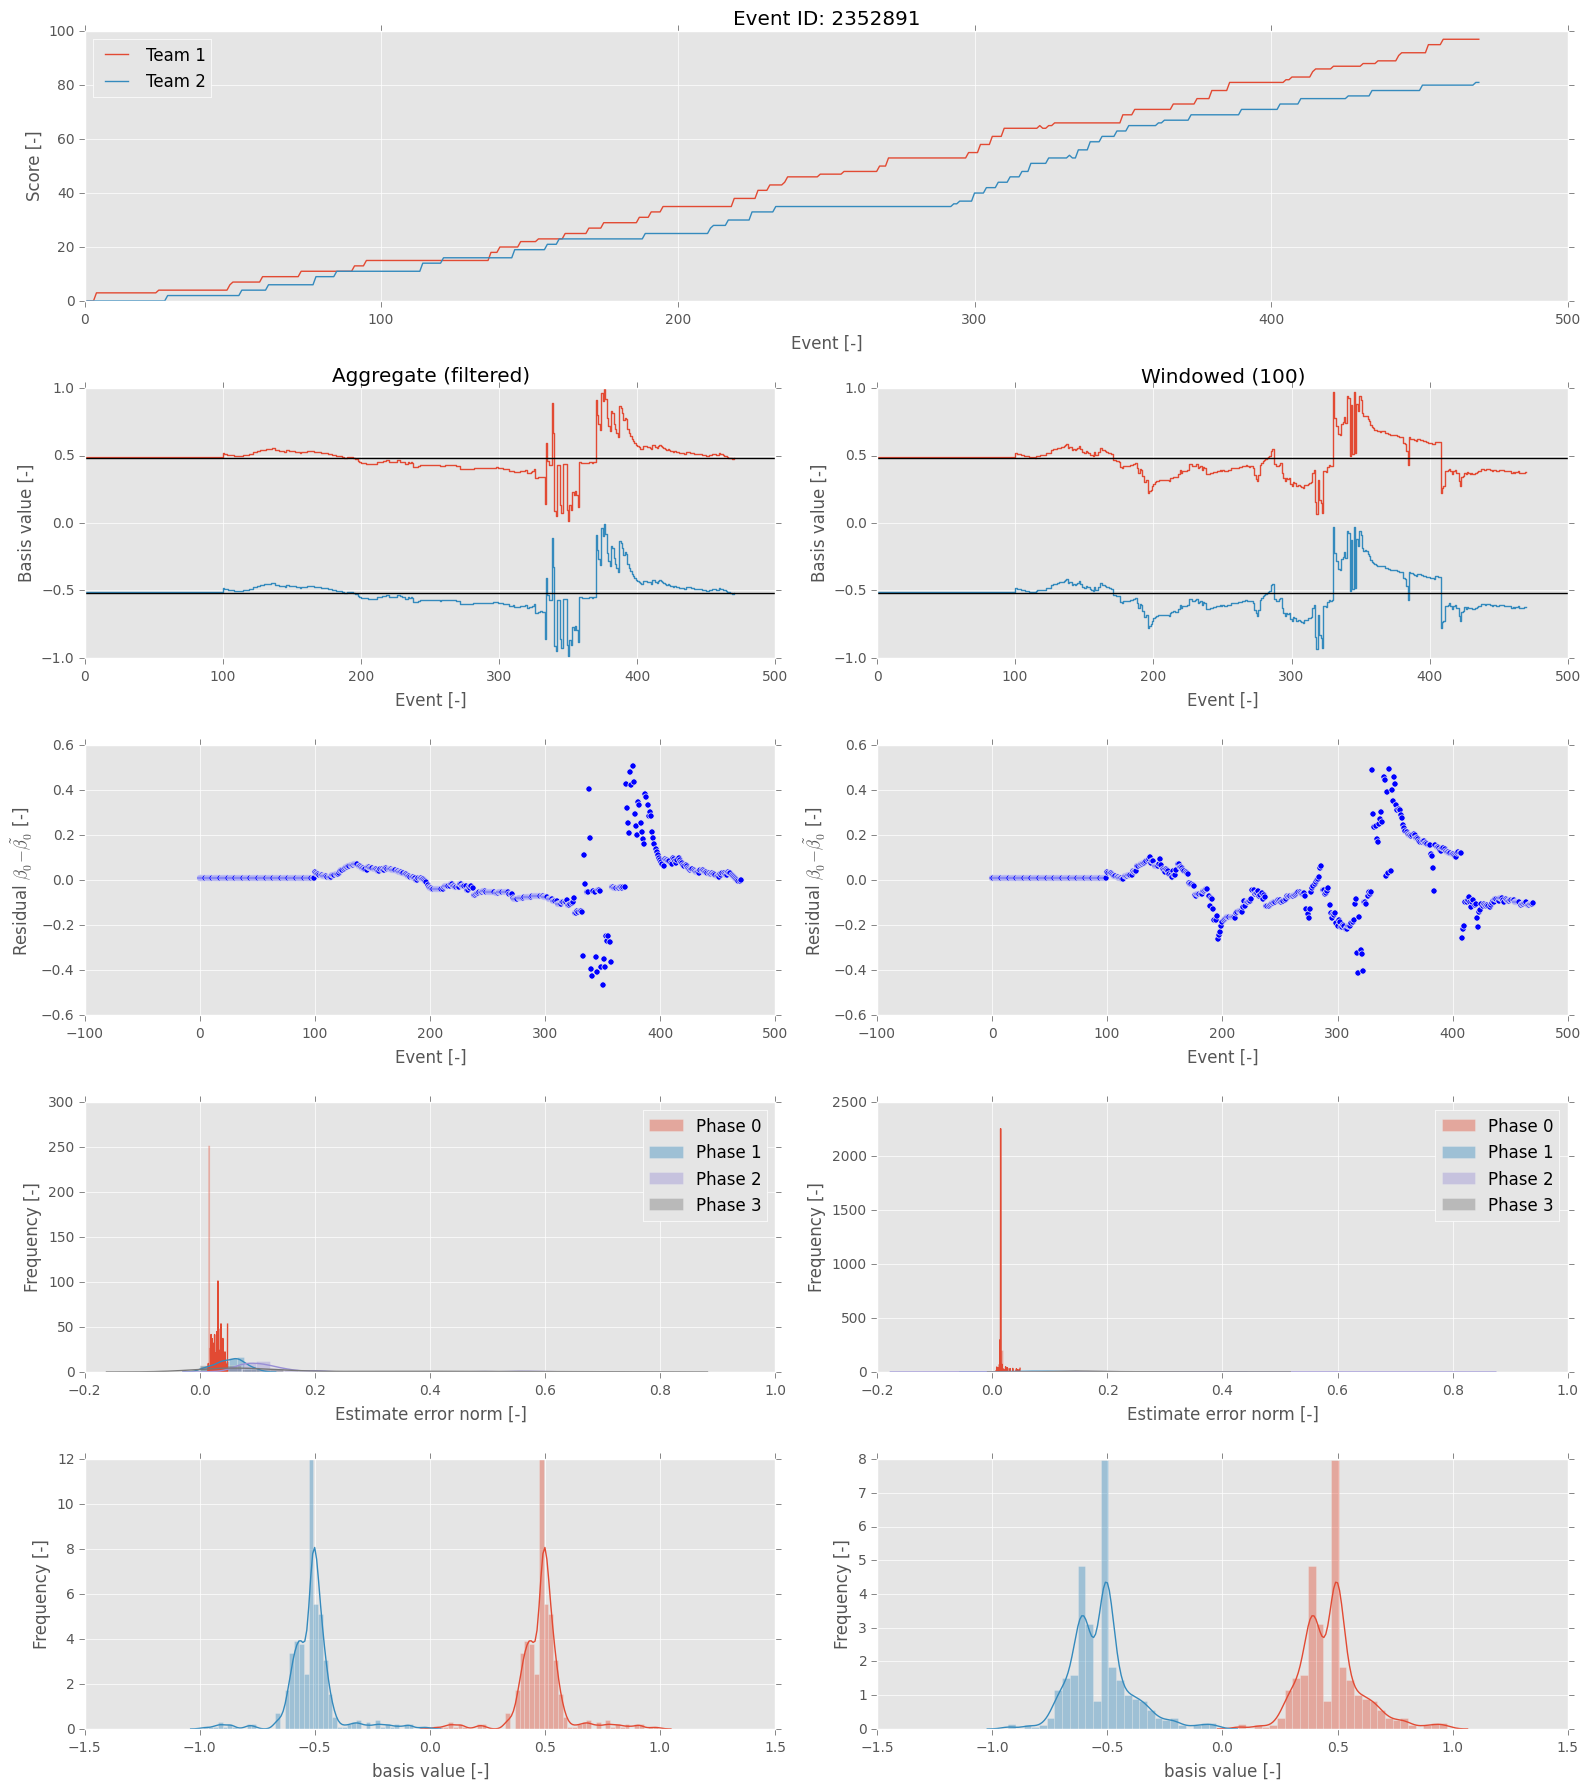

In [18]:
do_analysis(2352891)

First half:  [ 0.45790791 -0.54209209]
Second half: [ 0.45660108 -0.54339892]
Full match:  [ 0.44567799 -0.55432201]


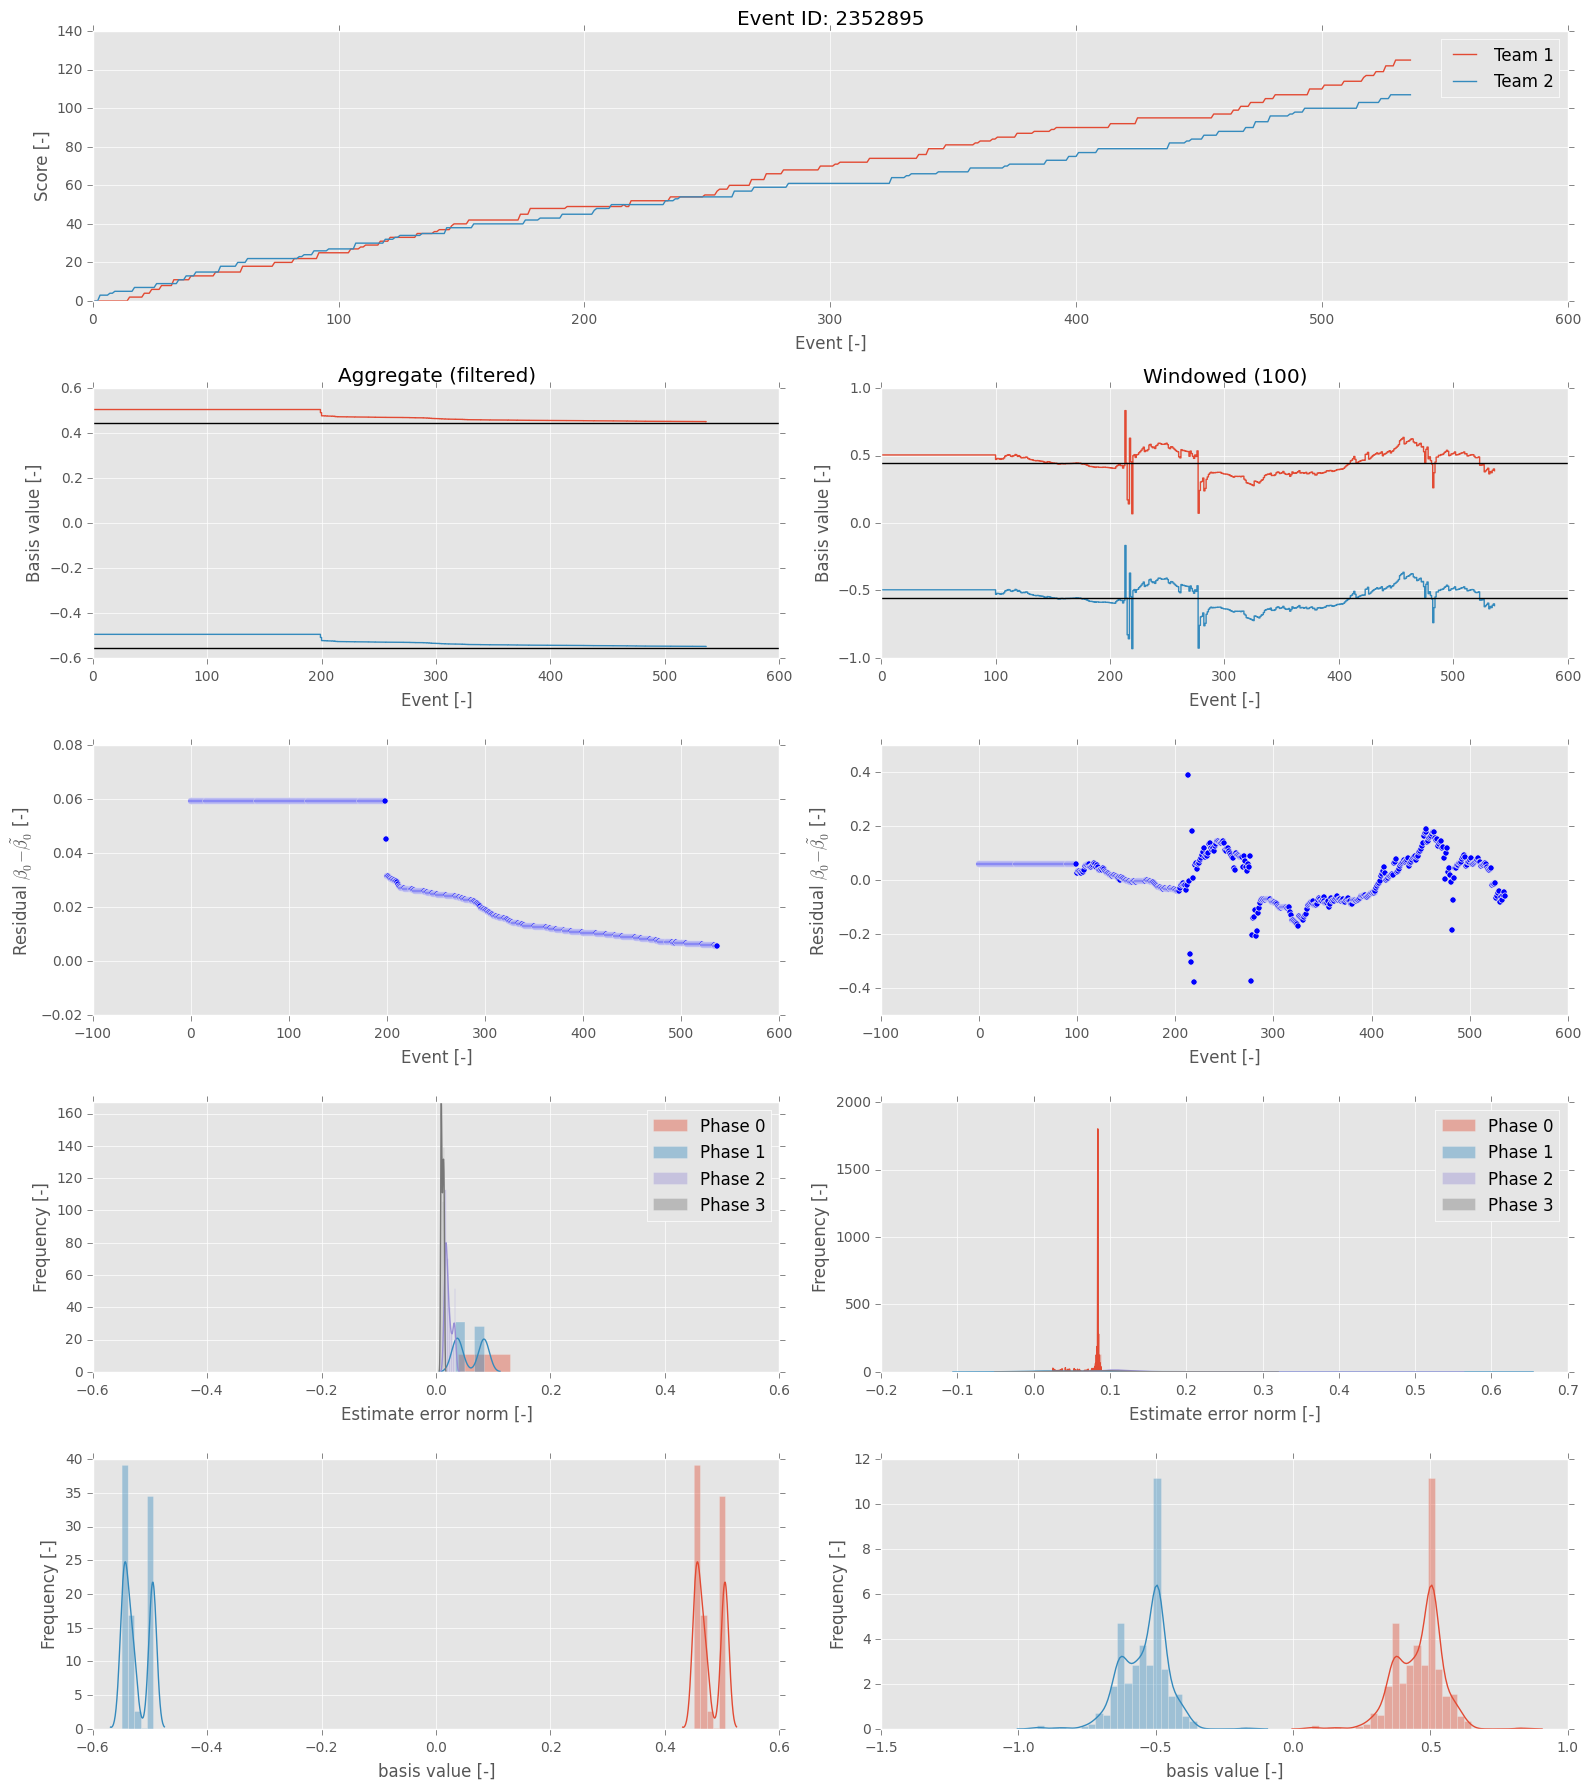

In [133]:
do_analysis(2352895)

First half:  [ 0.43917736 -0.56082264]
Second half: [ 0.5403577 -0.4596423]
Full match:  [ 0.50950267 -0.49049733]


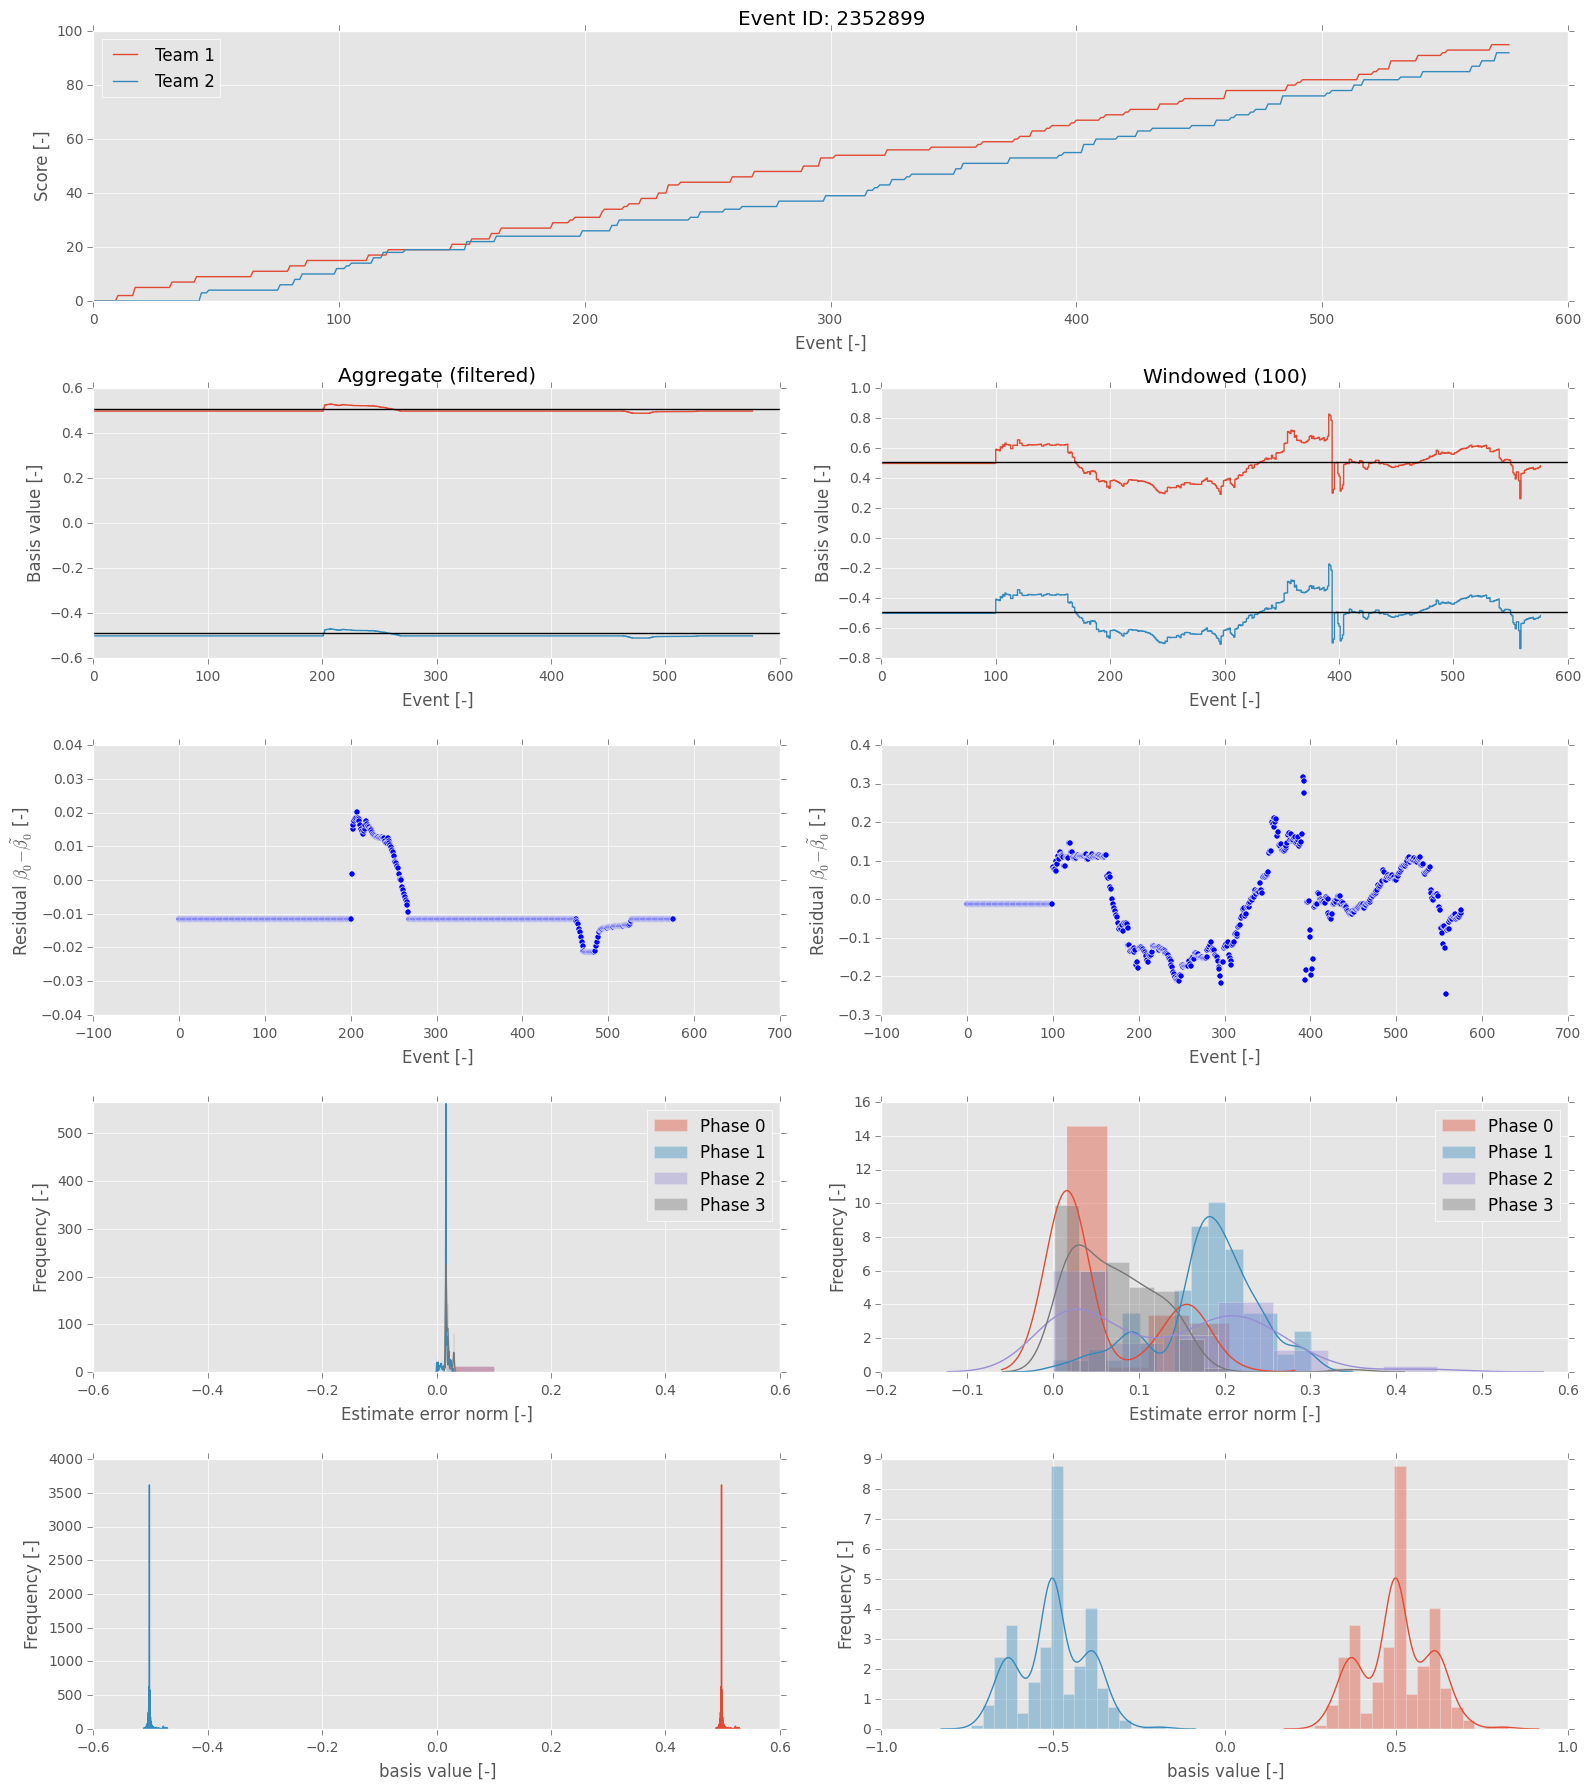

In [134]:
do_analysis(2352899)

First half:  [ 0.55377424 -0.44622576]
Second half: [ 0.59261526 -0.40738474]
Full match:  [ 0.549017 -0.450983]


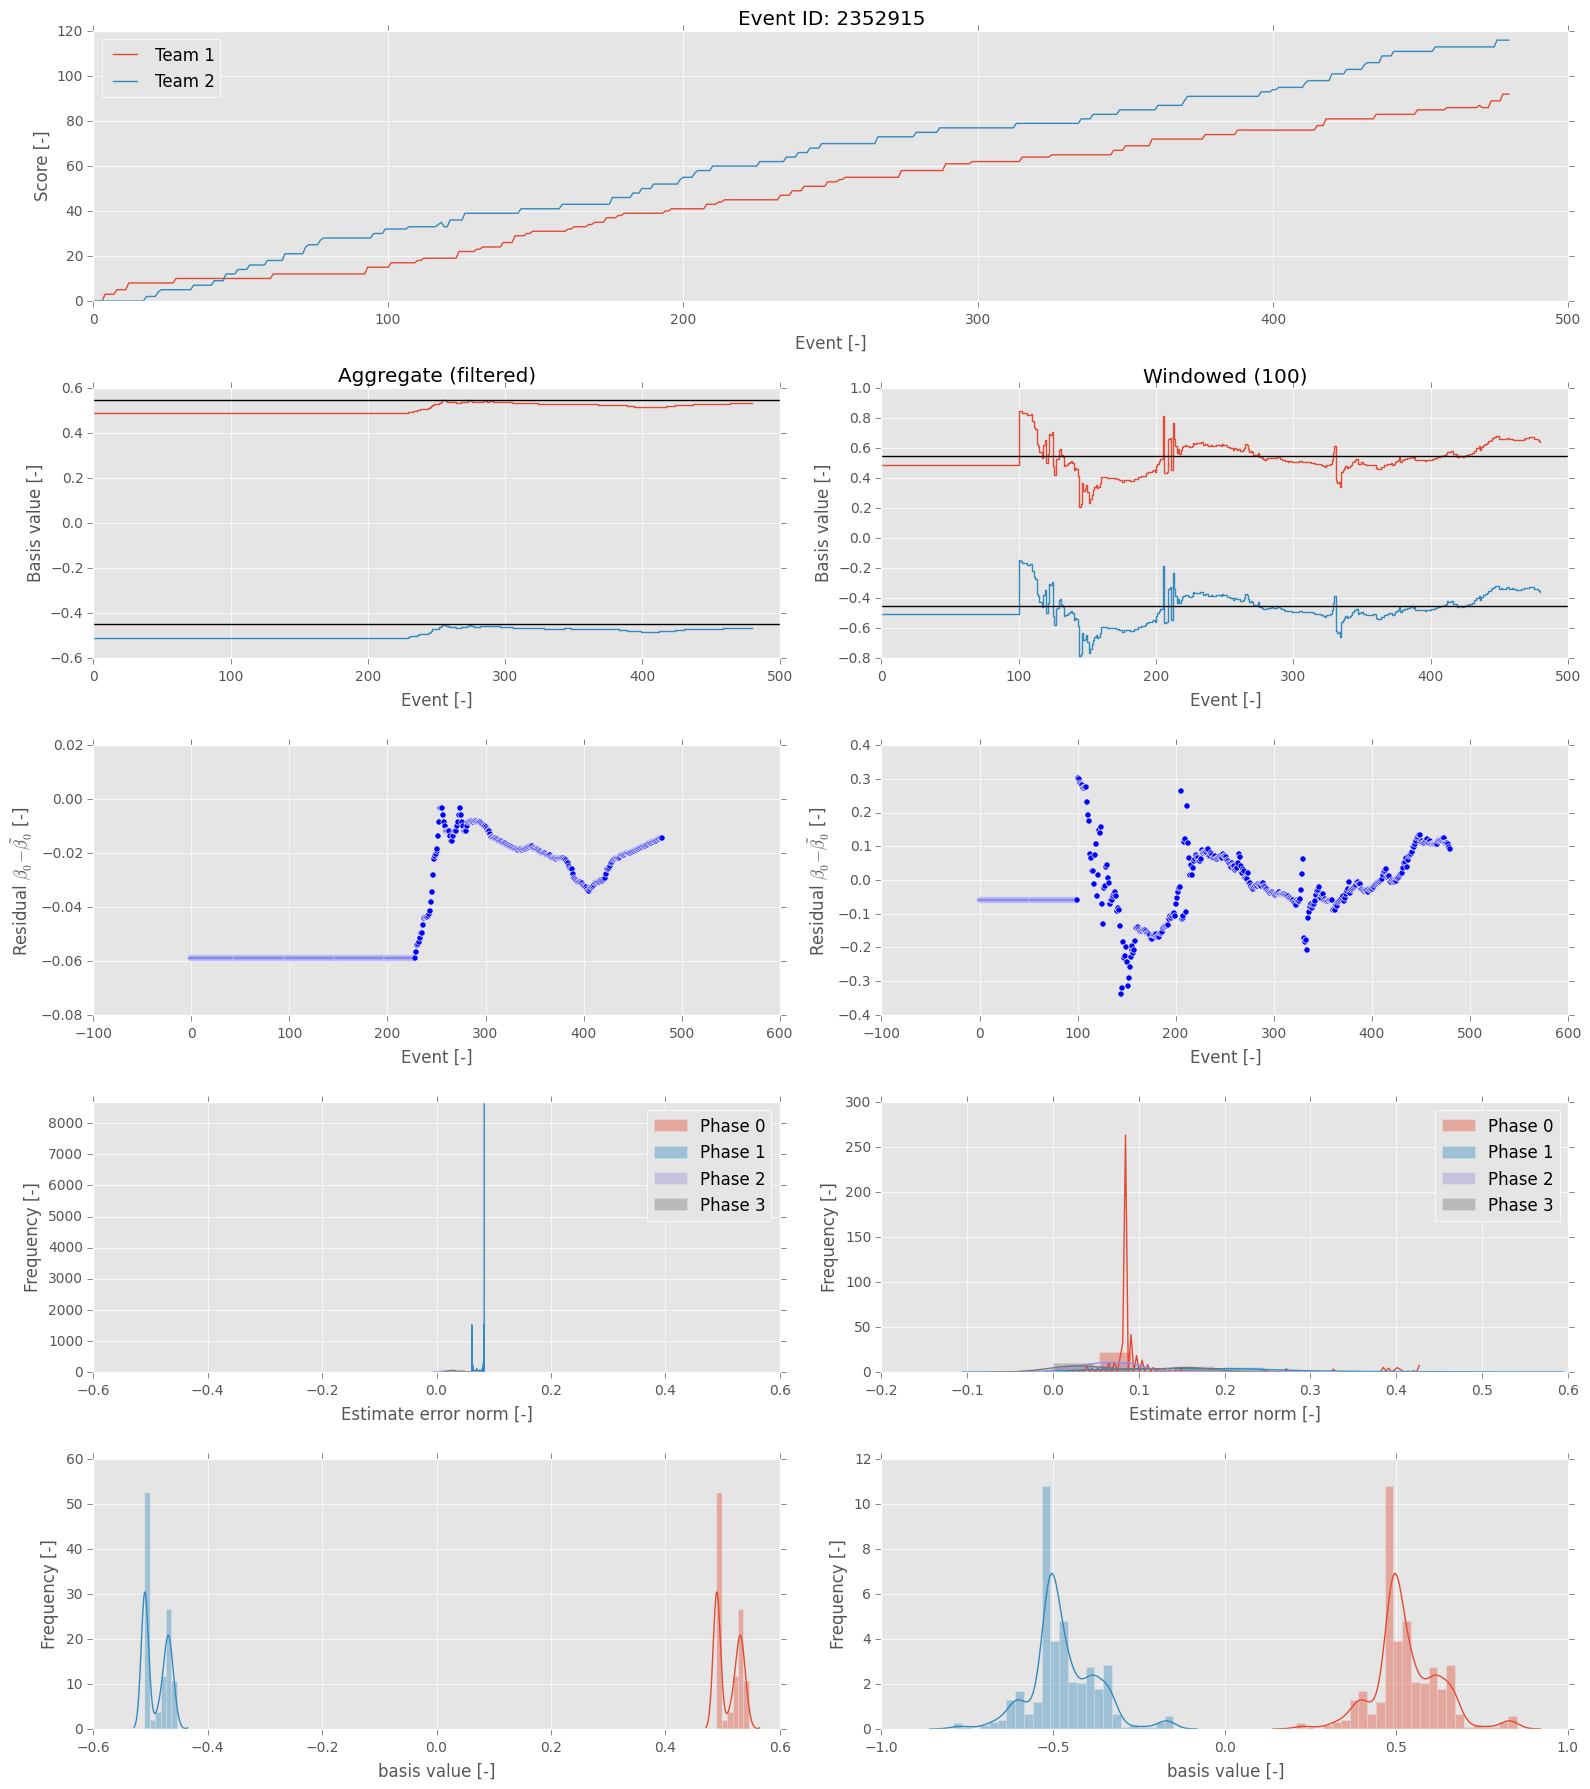

In [135]:
do_analysis(2352915)

First half:  [ 0.54591147 -0.45408853]
Second half: [ 0.84508863 -0.15491137]
Full match:  [ 0.60054044 -0.39945956]


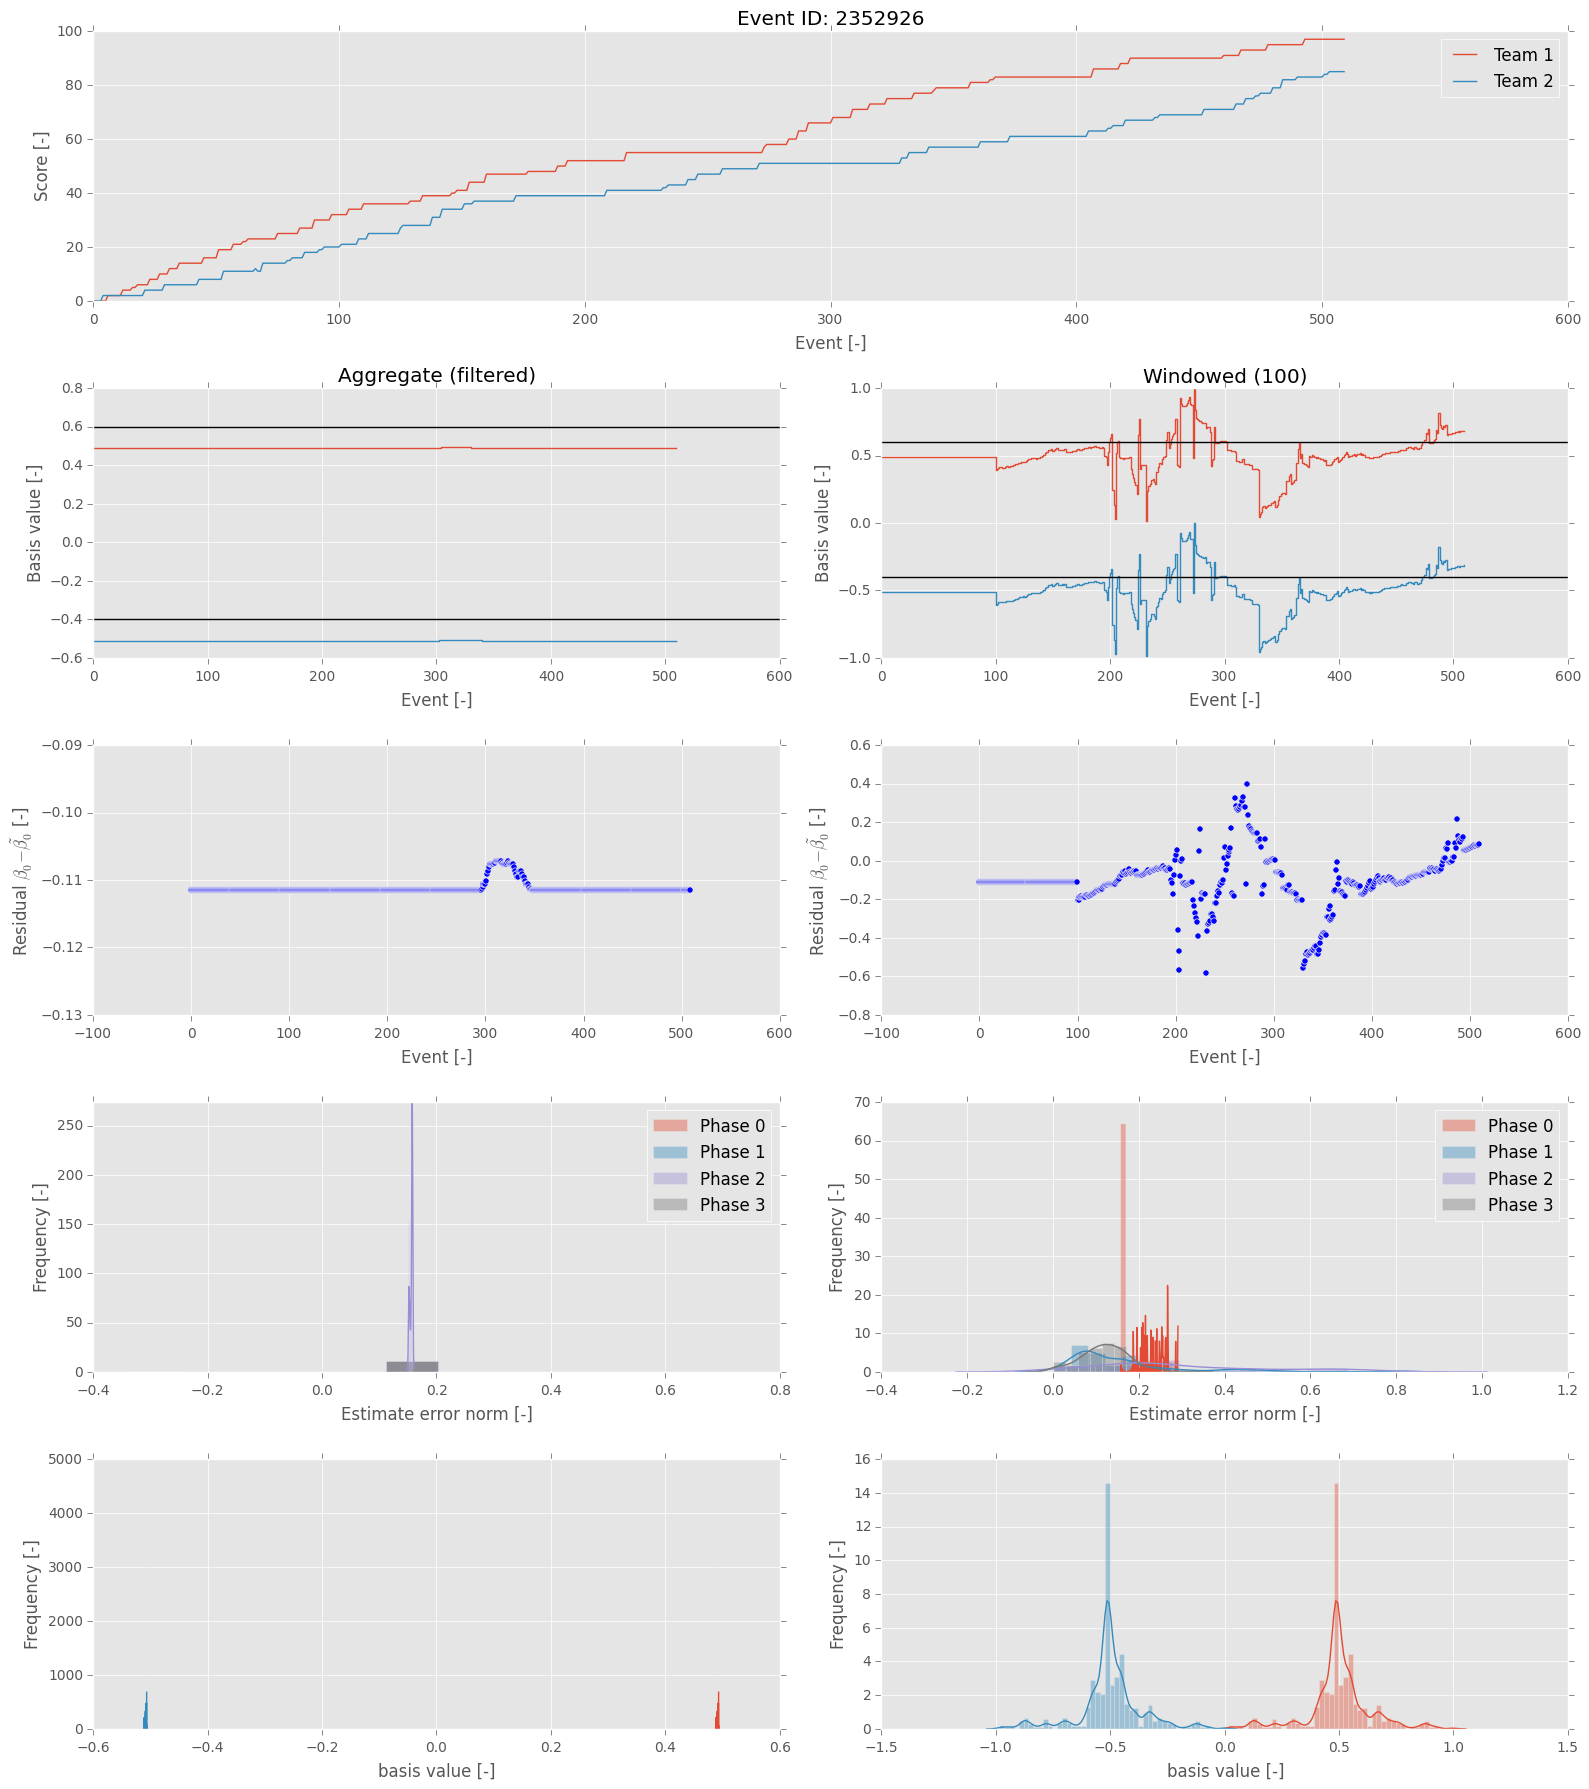

In [136]:
do_analysis(2352926)

First half:  [ 0.32703134 -0.67296866]
Second half: [ 0.44642566 -0.55357434]
Full match:  [ 0.53005027 -0.46994973]


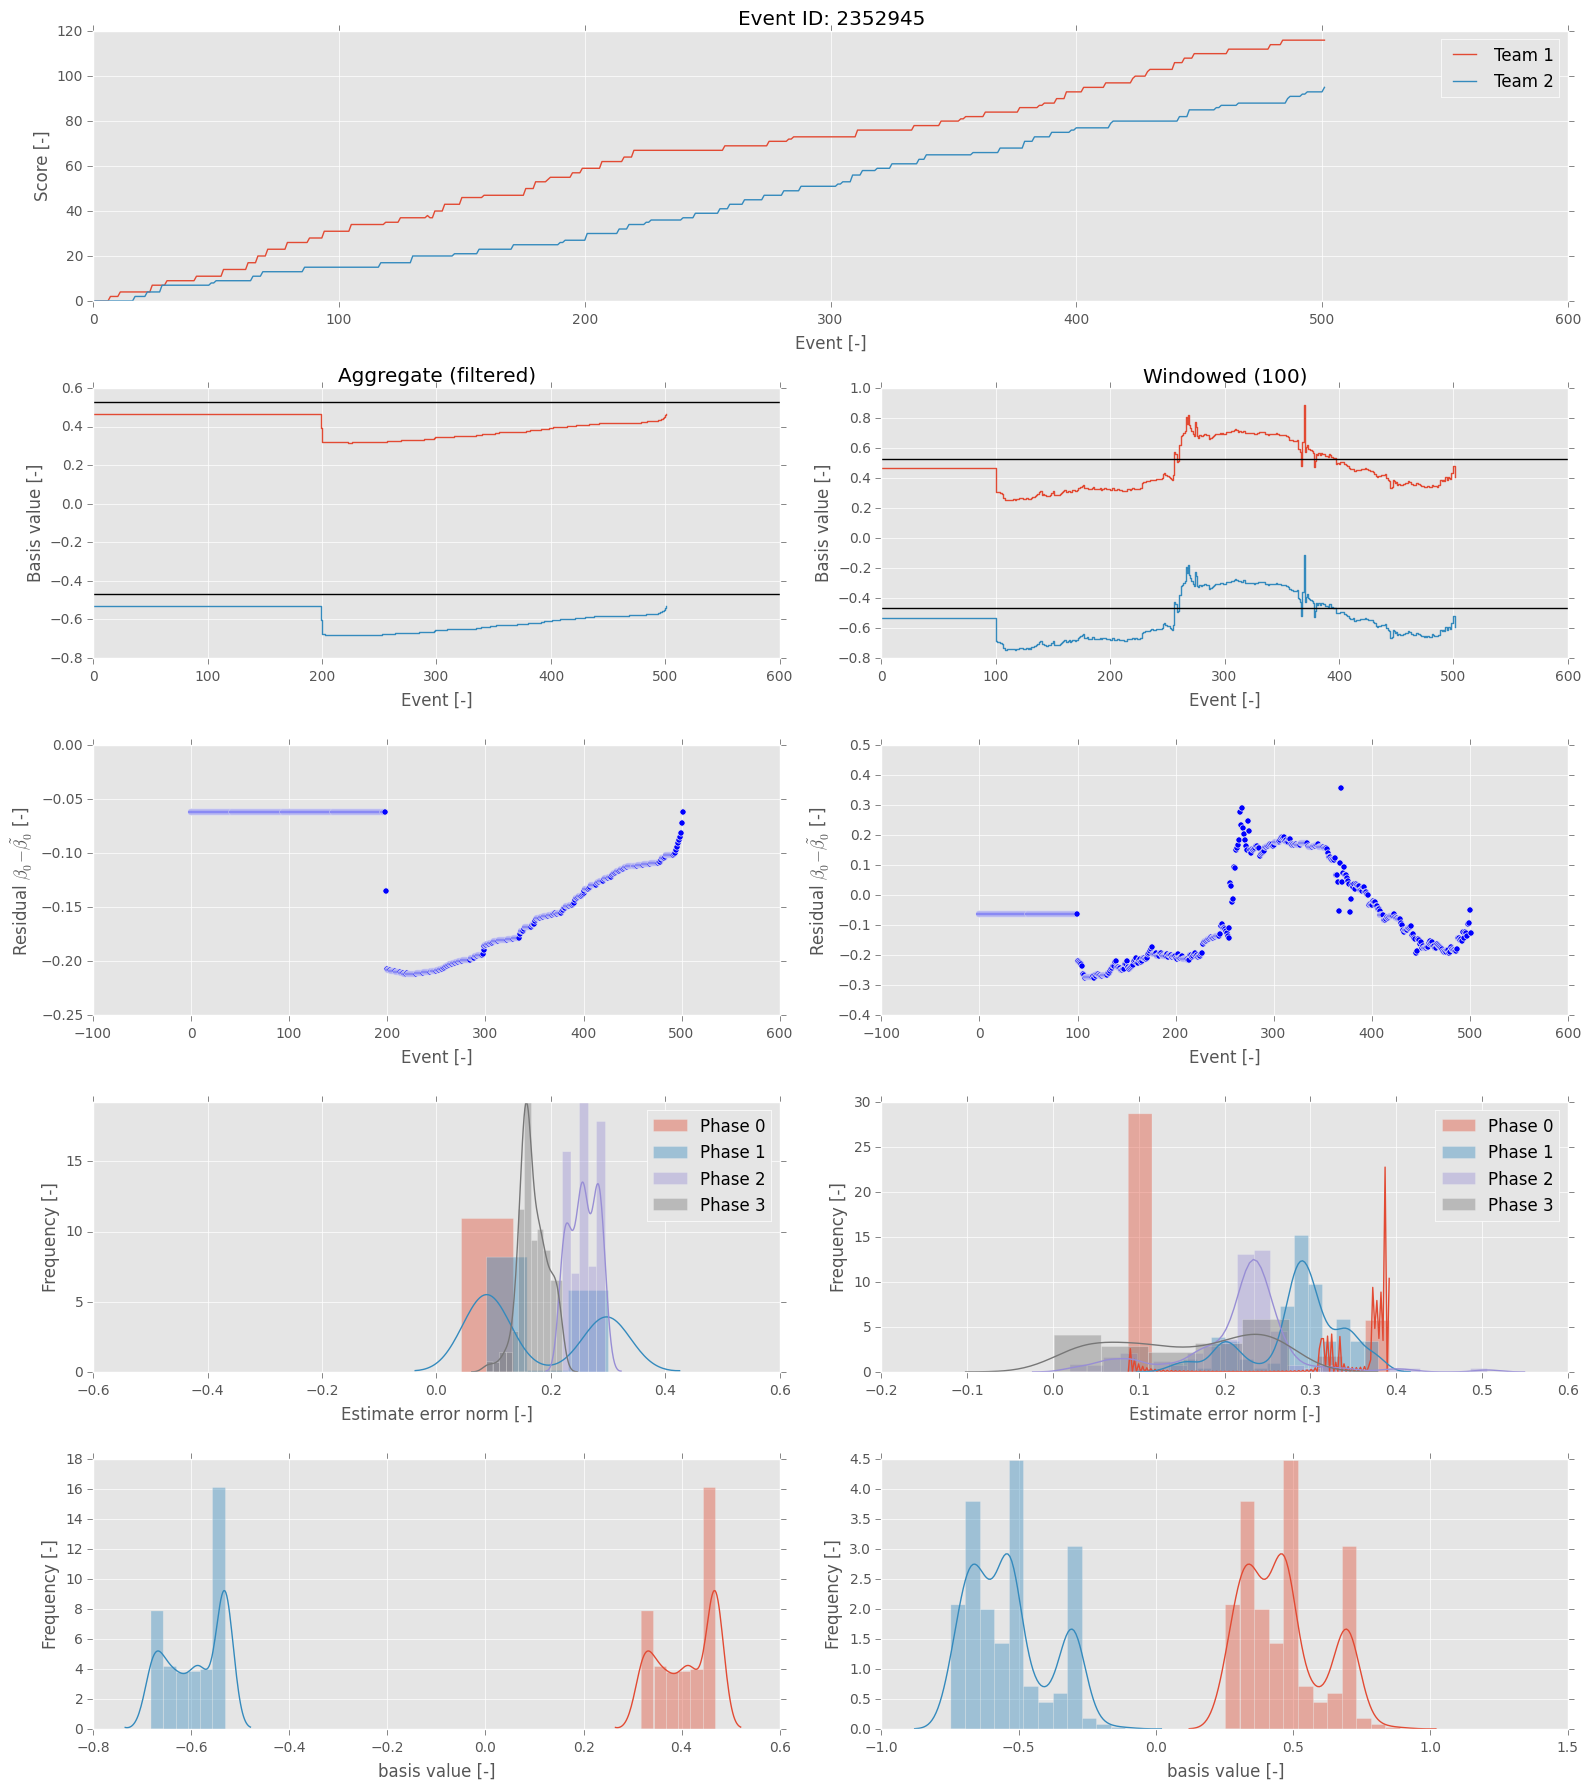

In [137]:
do_analysis(2352945)

First half:  [ 0.58173173 -0.41826827]
Second half: [ 0.48924272 -0.51075728]
Full match:  [ 0.59468763 -0.40531237]


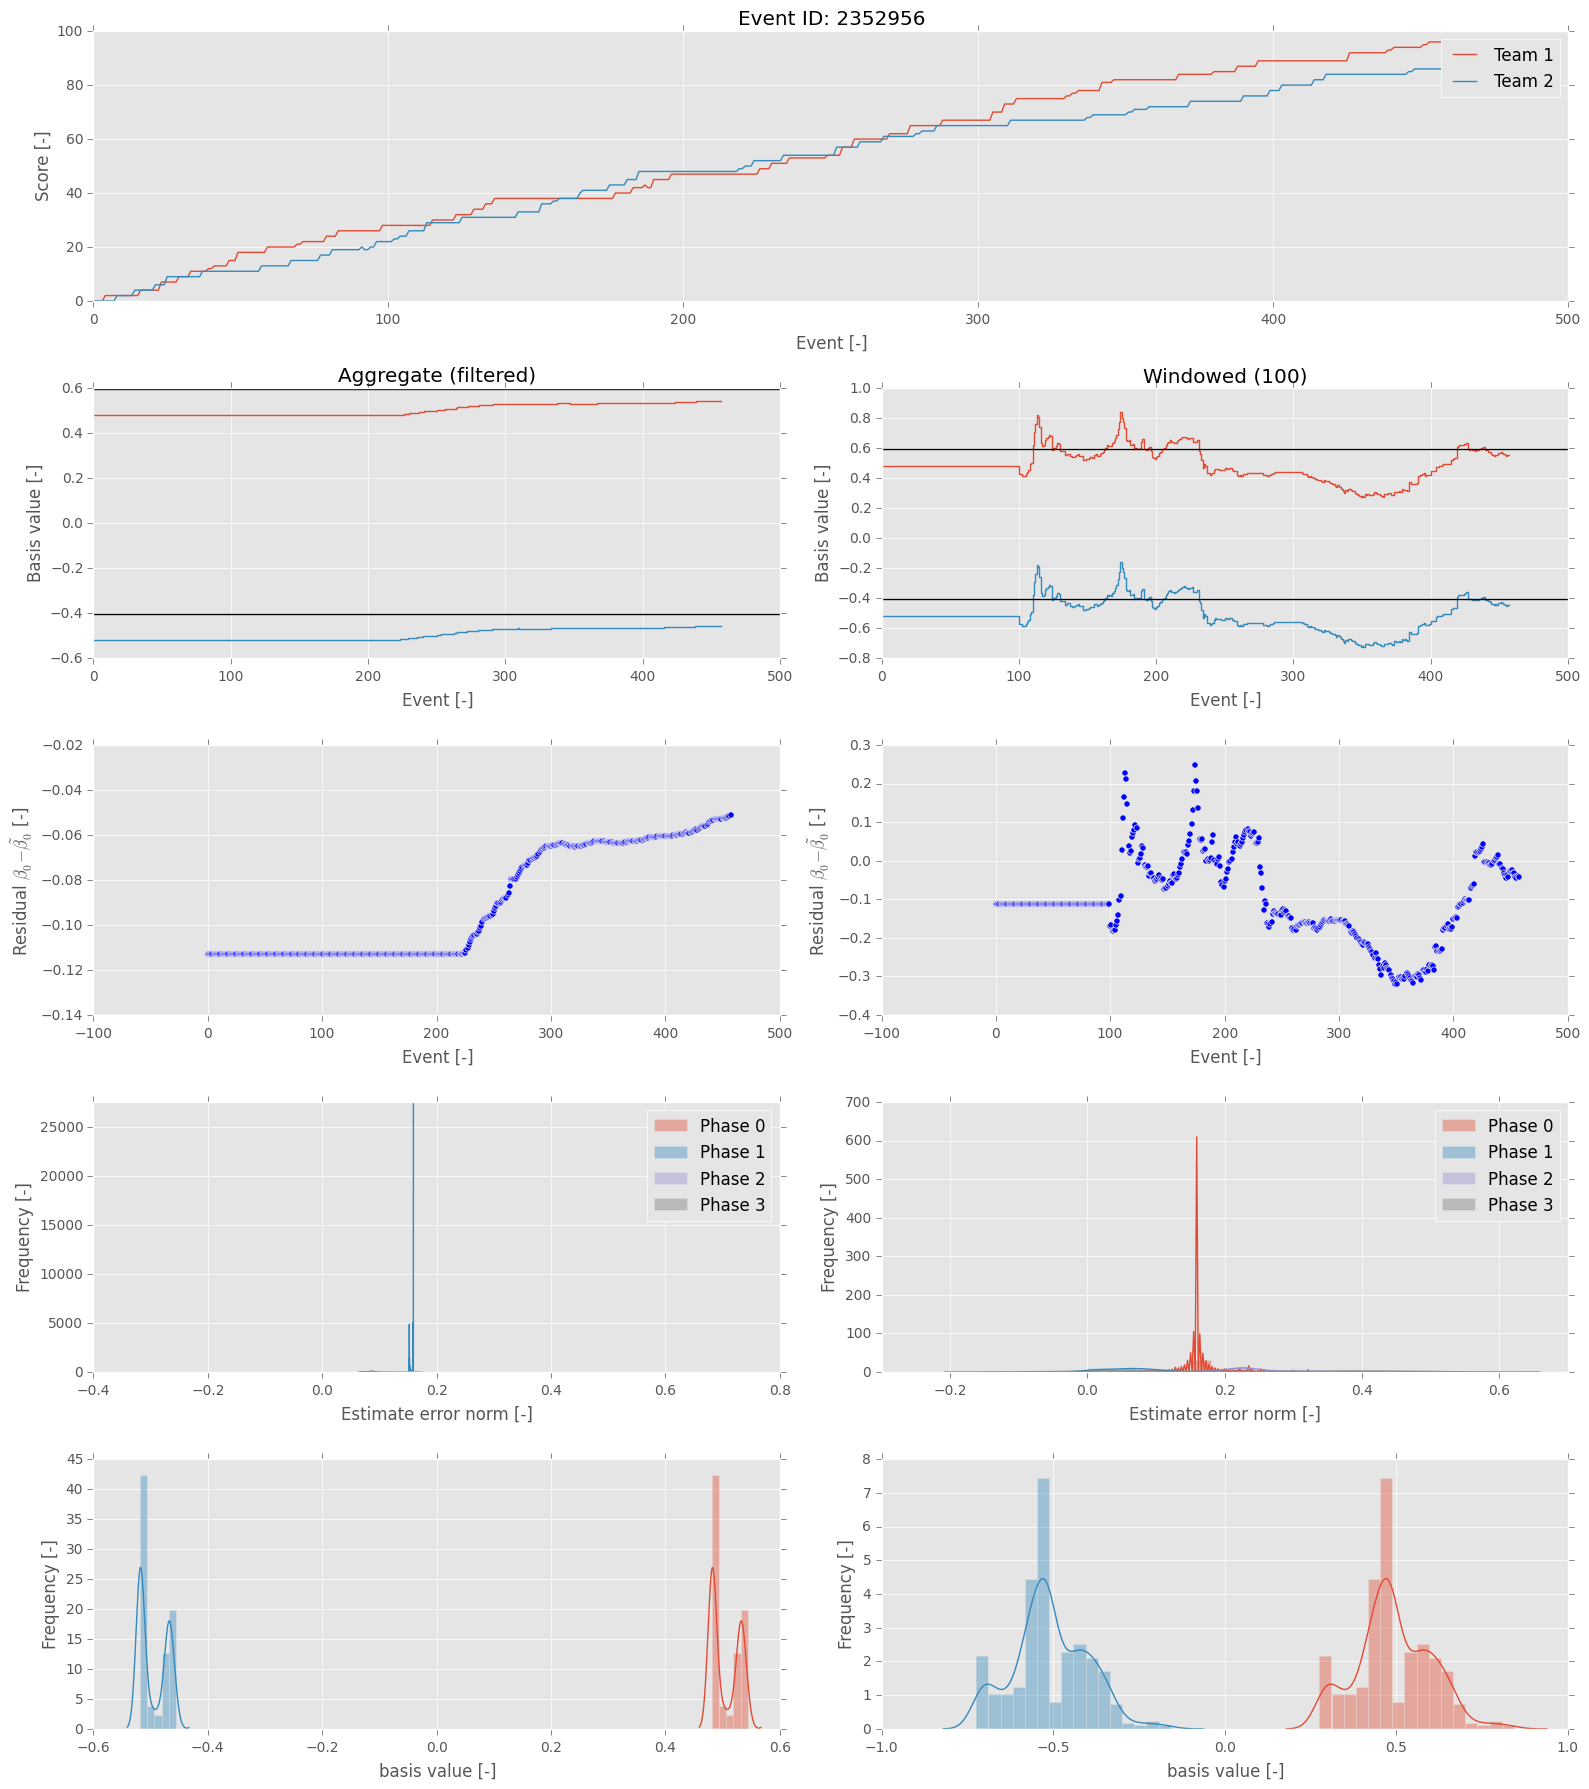

In [138]:
do_analysis(2352956)

First half:  [ 0.52223468 -0.47776532]
Second half: [ 0.58256892 -0.41743108]
Full match:  [ 0.57179047 -0.42820953]


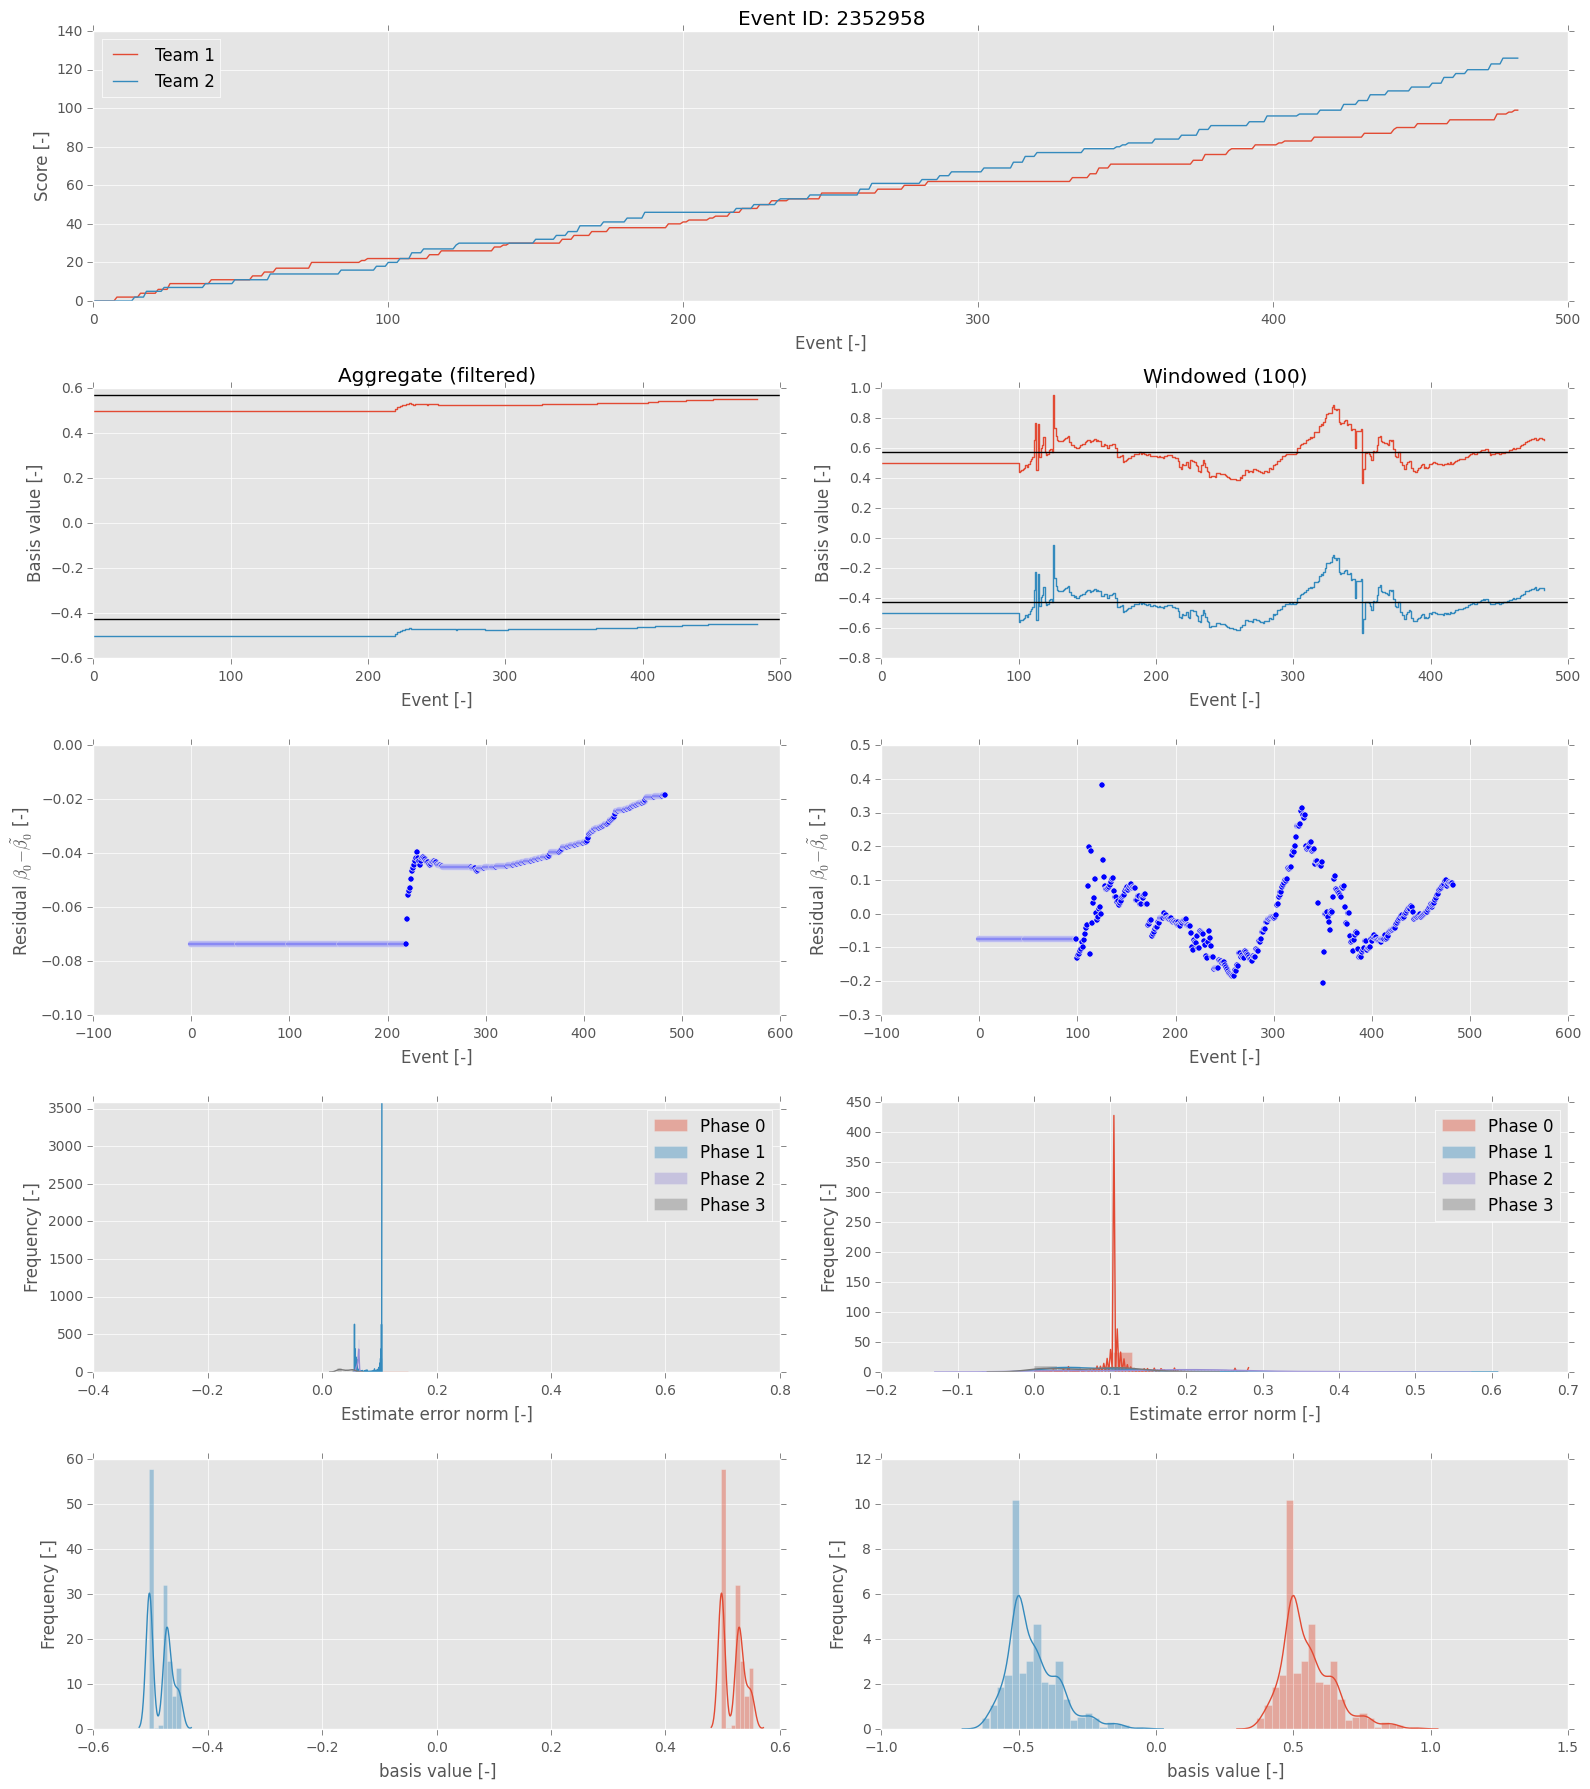

In [139]:
do_analysis(2352958)

First half:  [ 0.46873856 -0.53126144]
Second half: [ 0.5470569 -0.4529431]
Full match:  [ 0.54182918 -0.45817082]


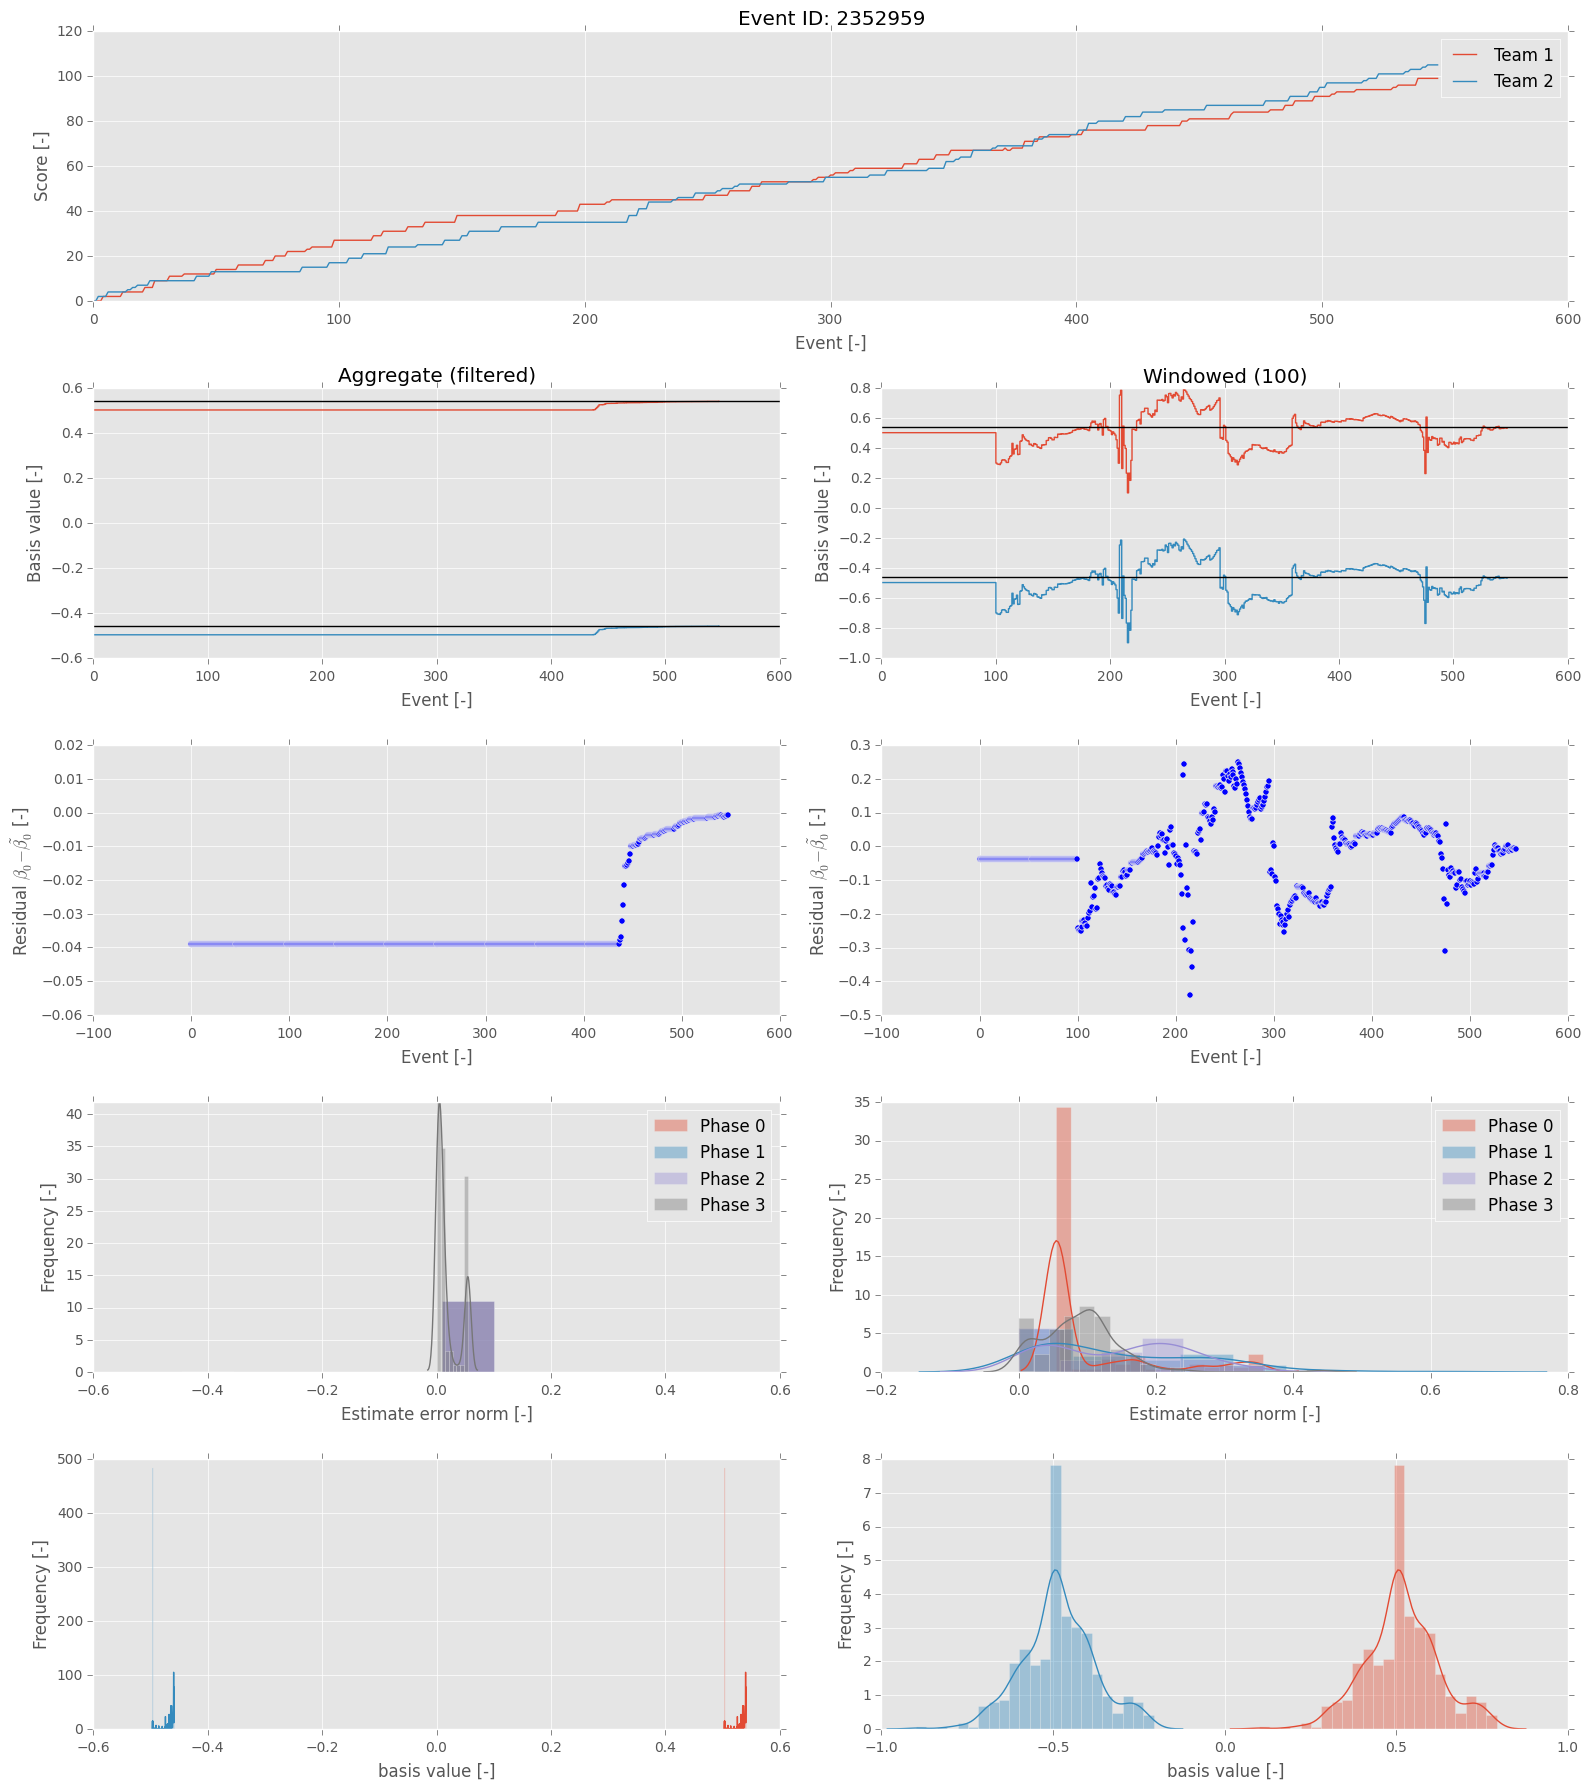

In [140]:
do_analysis(2352959)

First half:  [ 0.54072189 -0.45927811]
Second half: [ 0.47187174 -0.52812826]
Full match:  [ 0.50556845 -0.49443155]


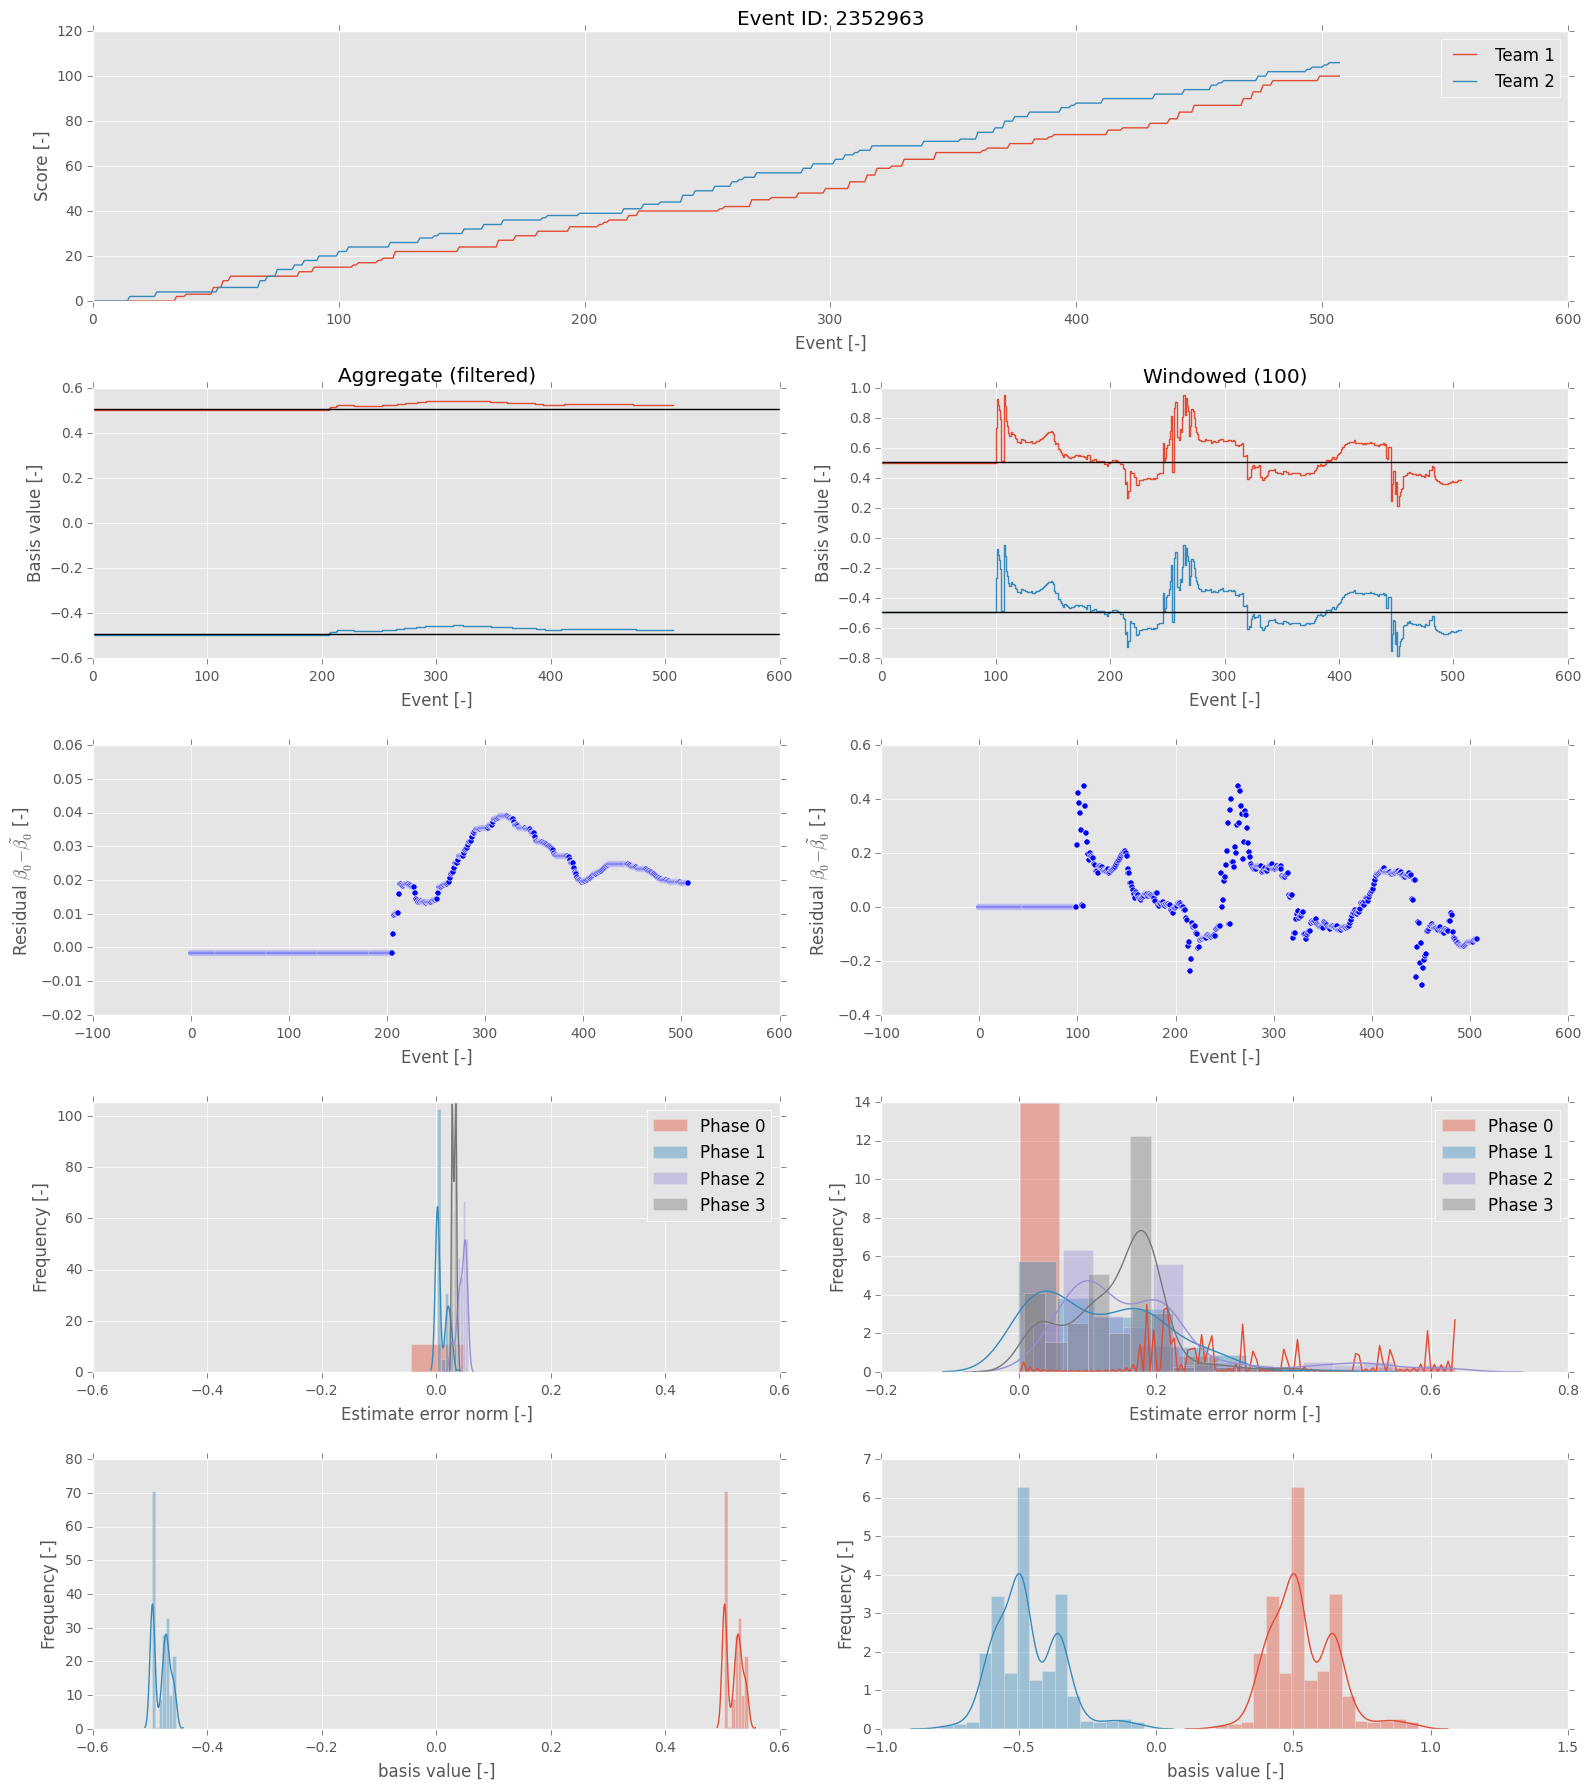

In [141]:
do_analysis(2352963)

First half:  [ 0.58016129 -0.41983871]
Second half: [ 0.5089848 -0.4910152]
Full match:  [ 0.51608786 -0.48391214]


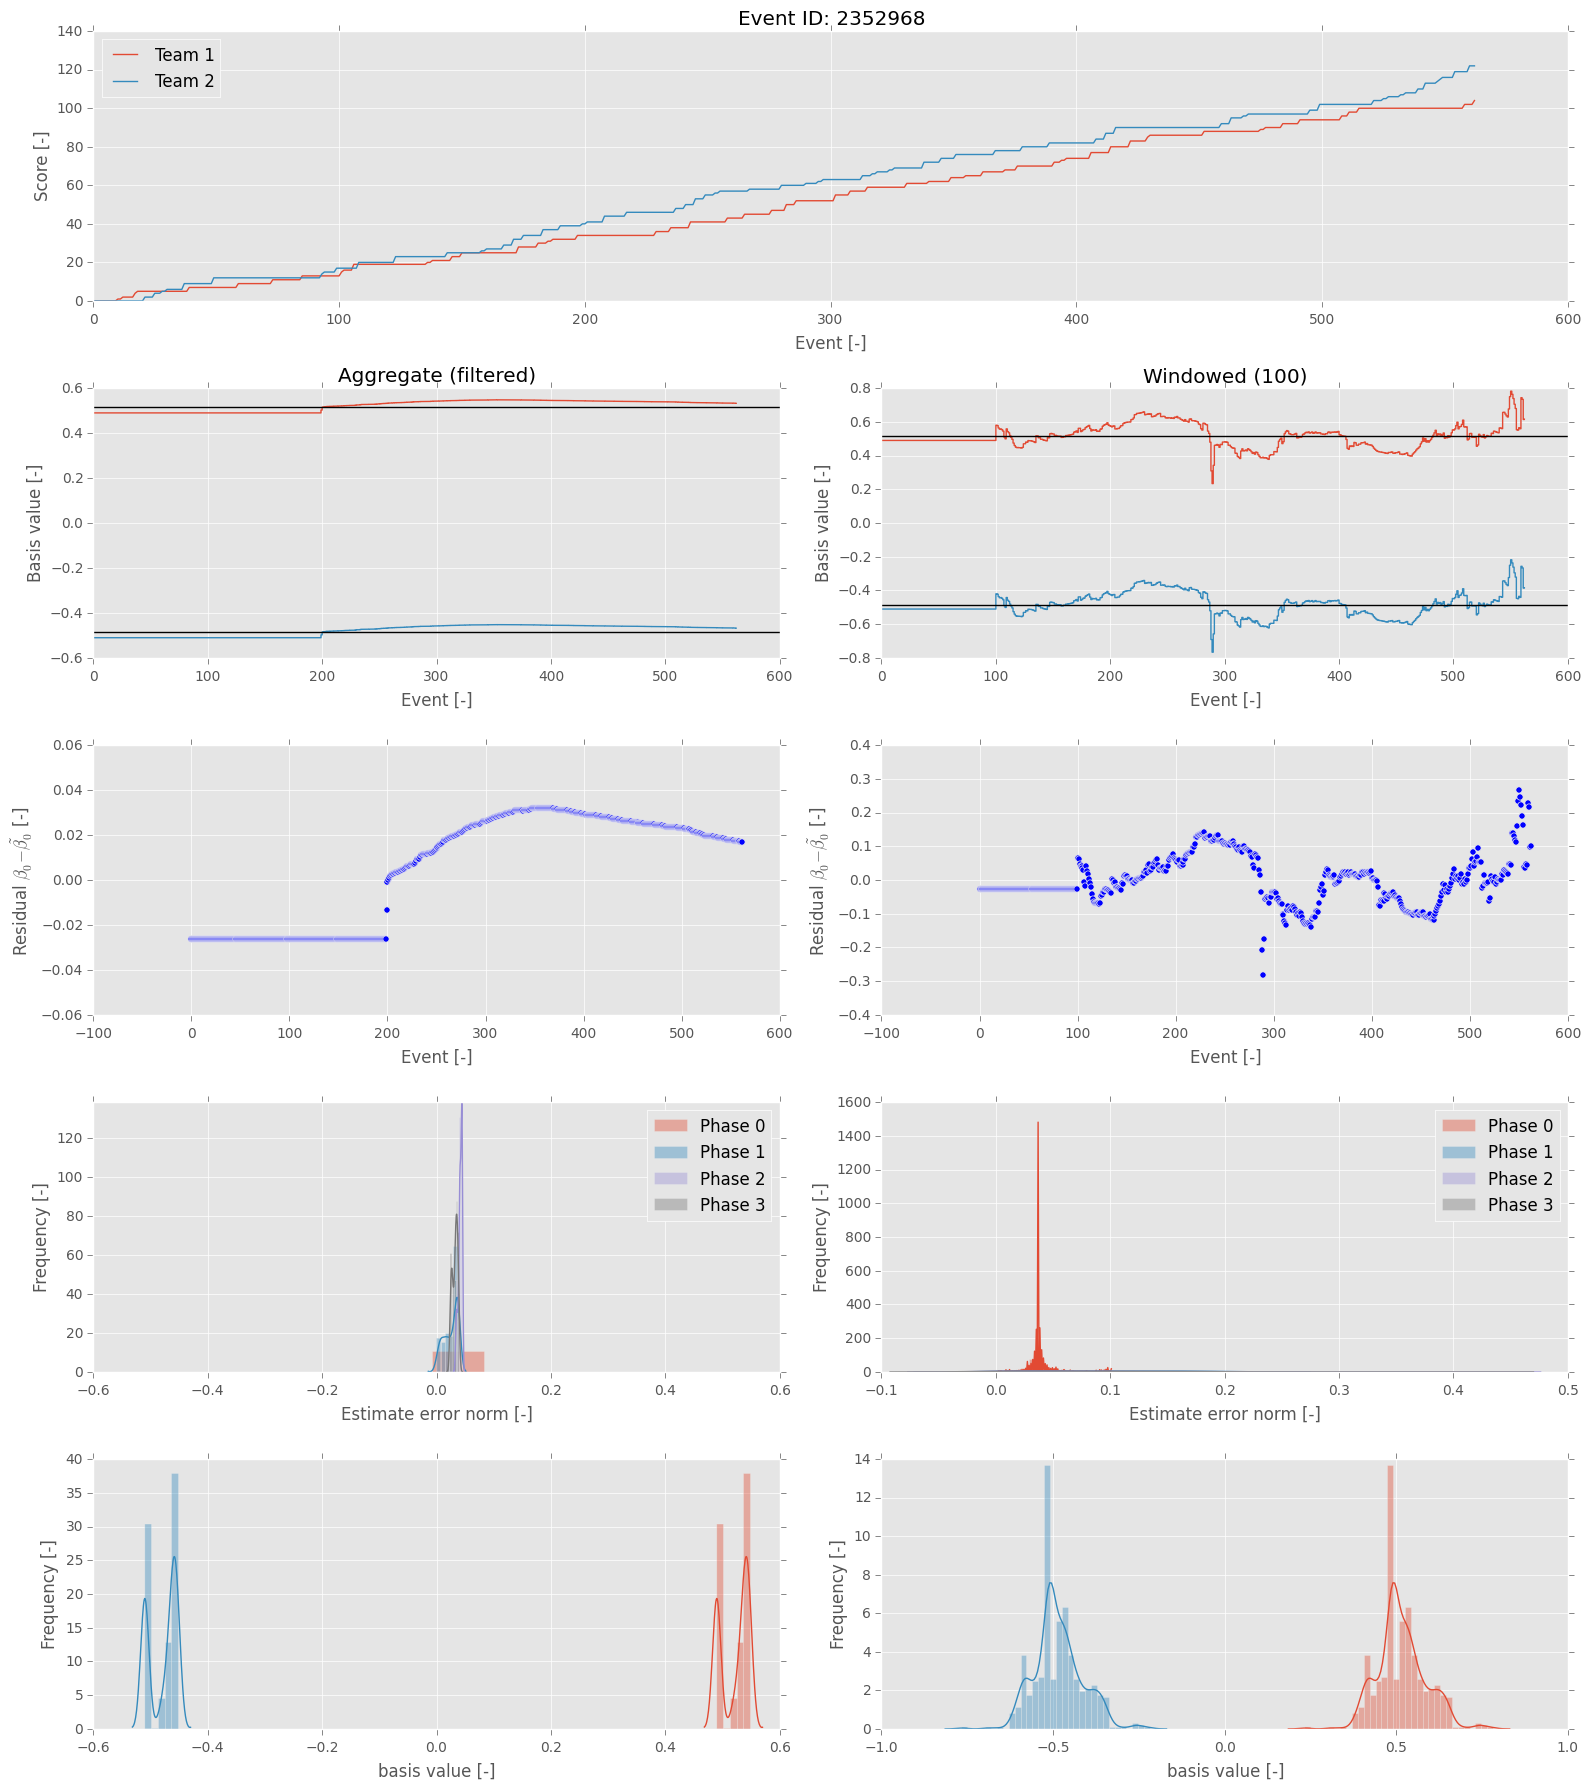

In [142]:
do_analysis(2352968)

First half:  [ 0.51271777 -0.48728223]
Second half: [ 0.42397576 -0.57602424]
Full match:  [ 0.48443142 -0.51556858]


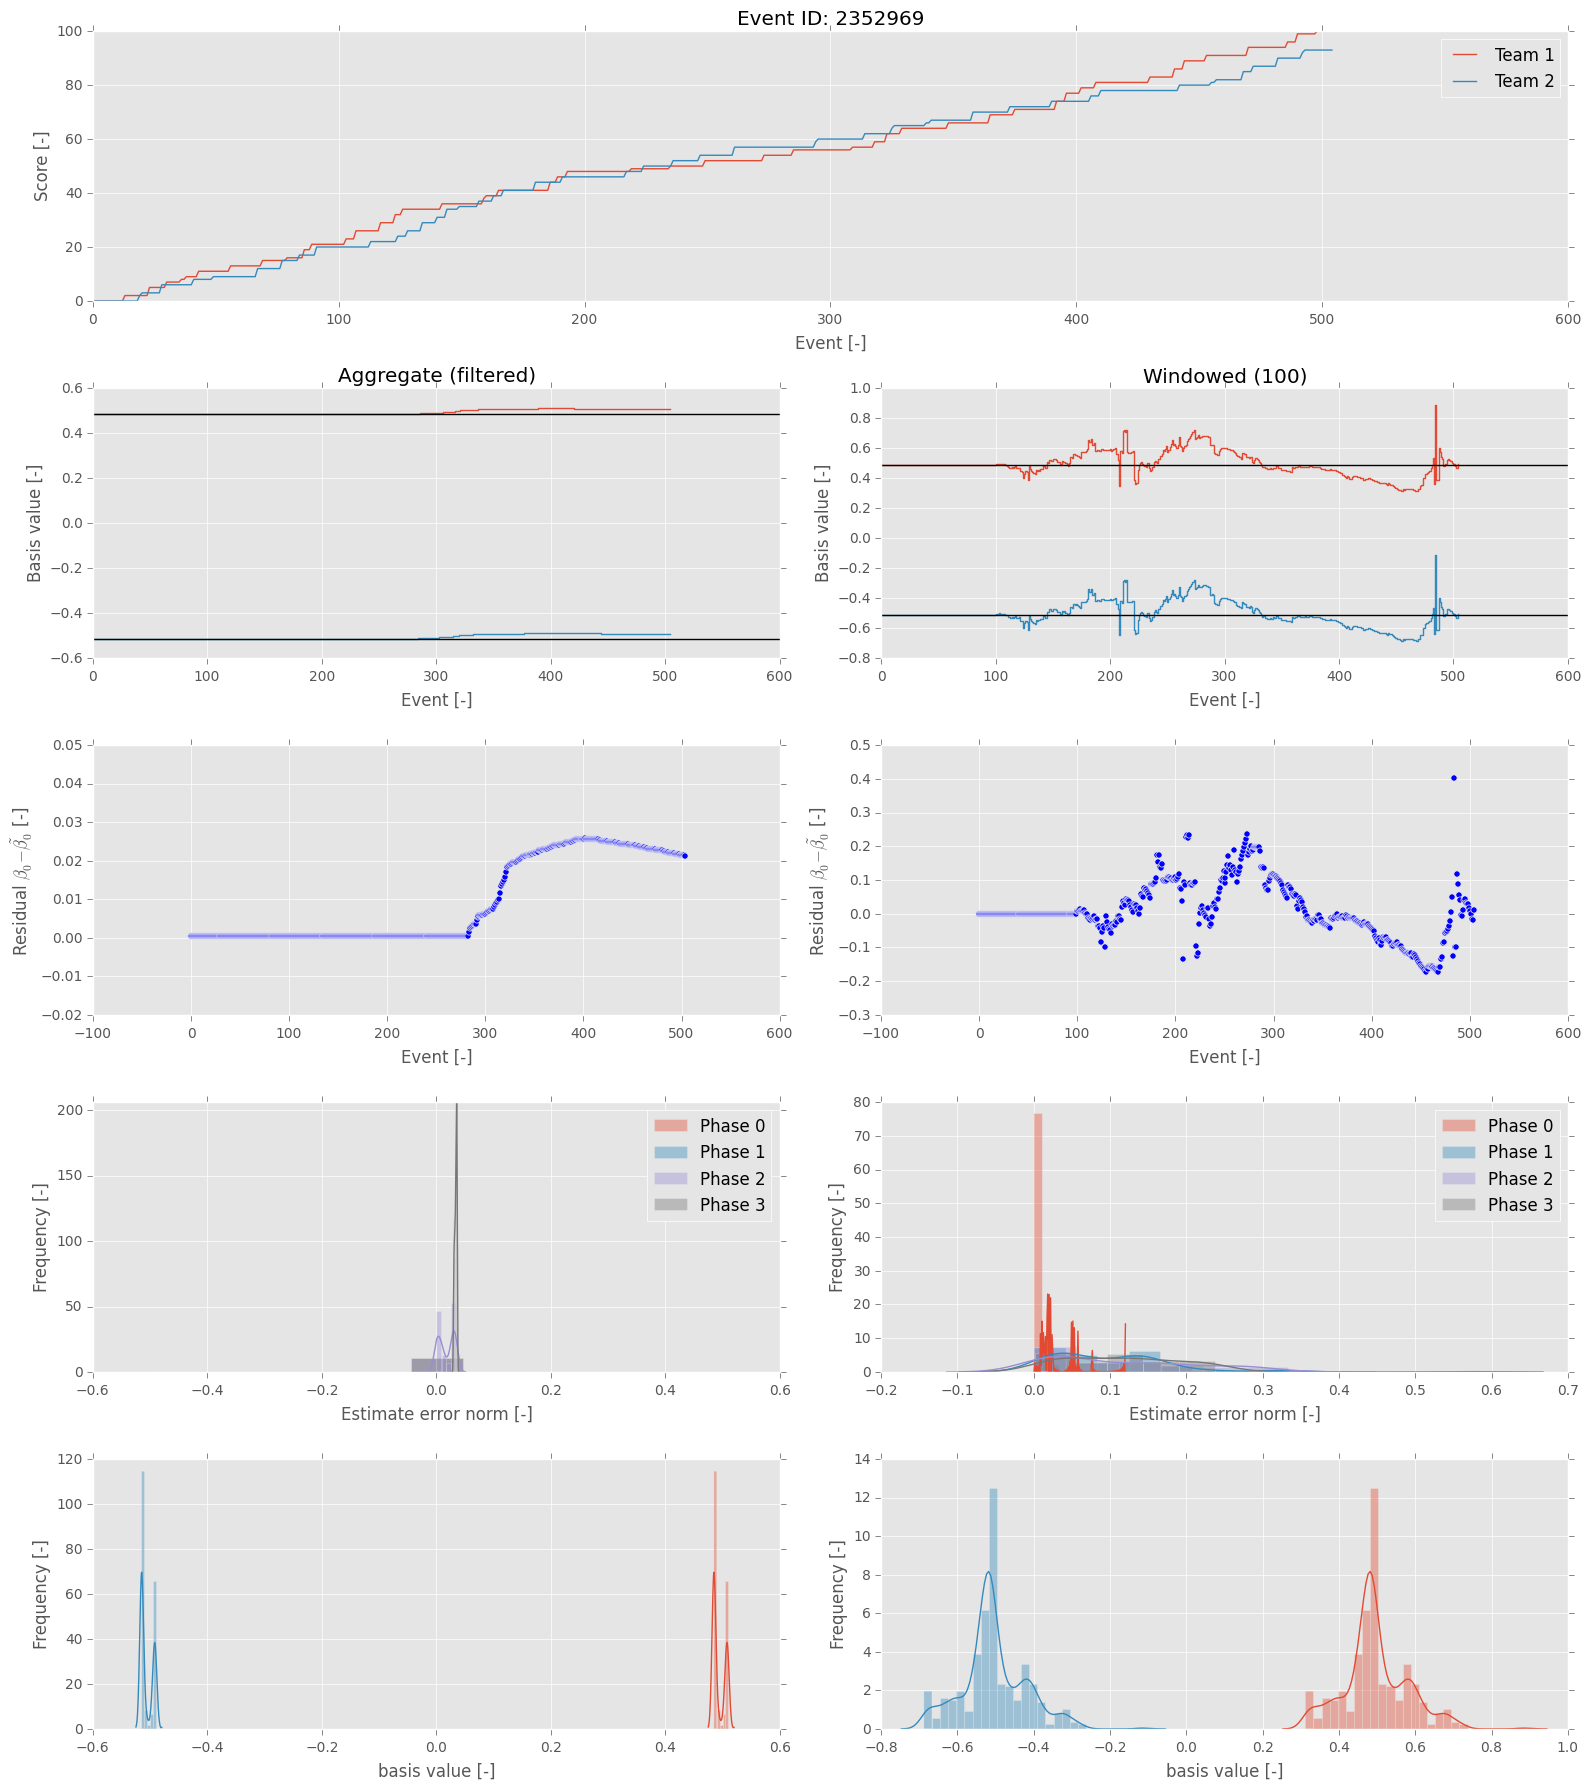

In [143]:
do_analysis(2352969)

First half:  [ 0.44152275 -0.55847725]
Second half: [ 0.56115646 -0.43884354]
Full match:  [ 0.27339406 -0.72660594]


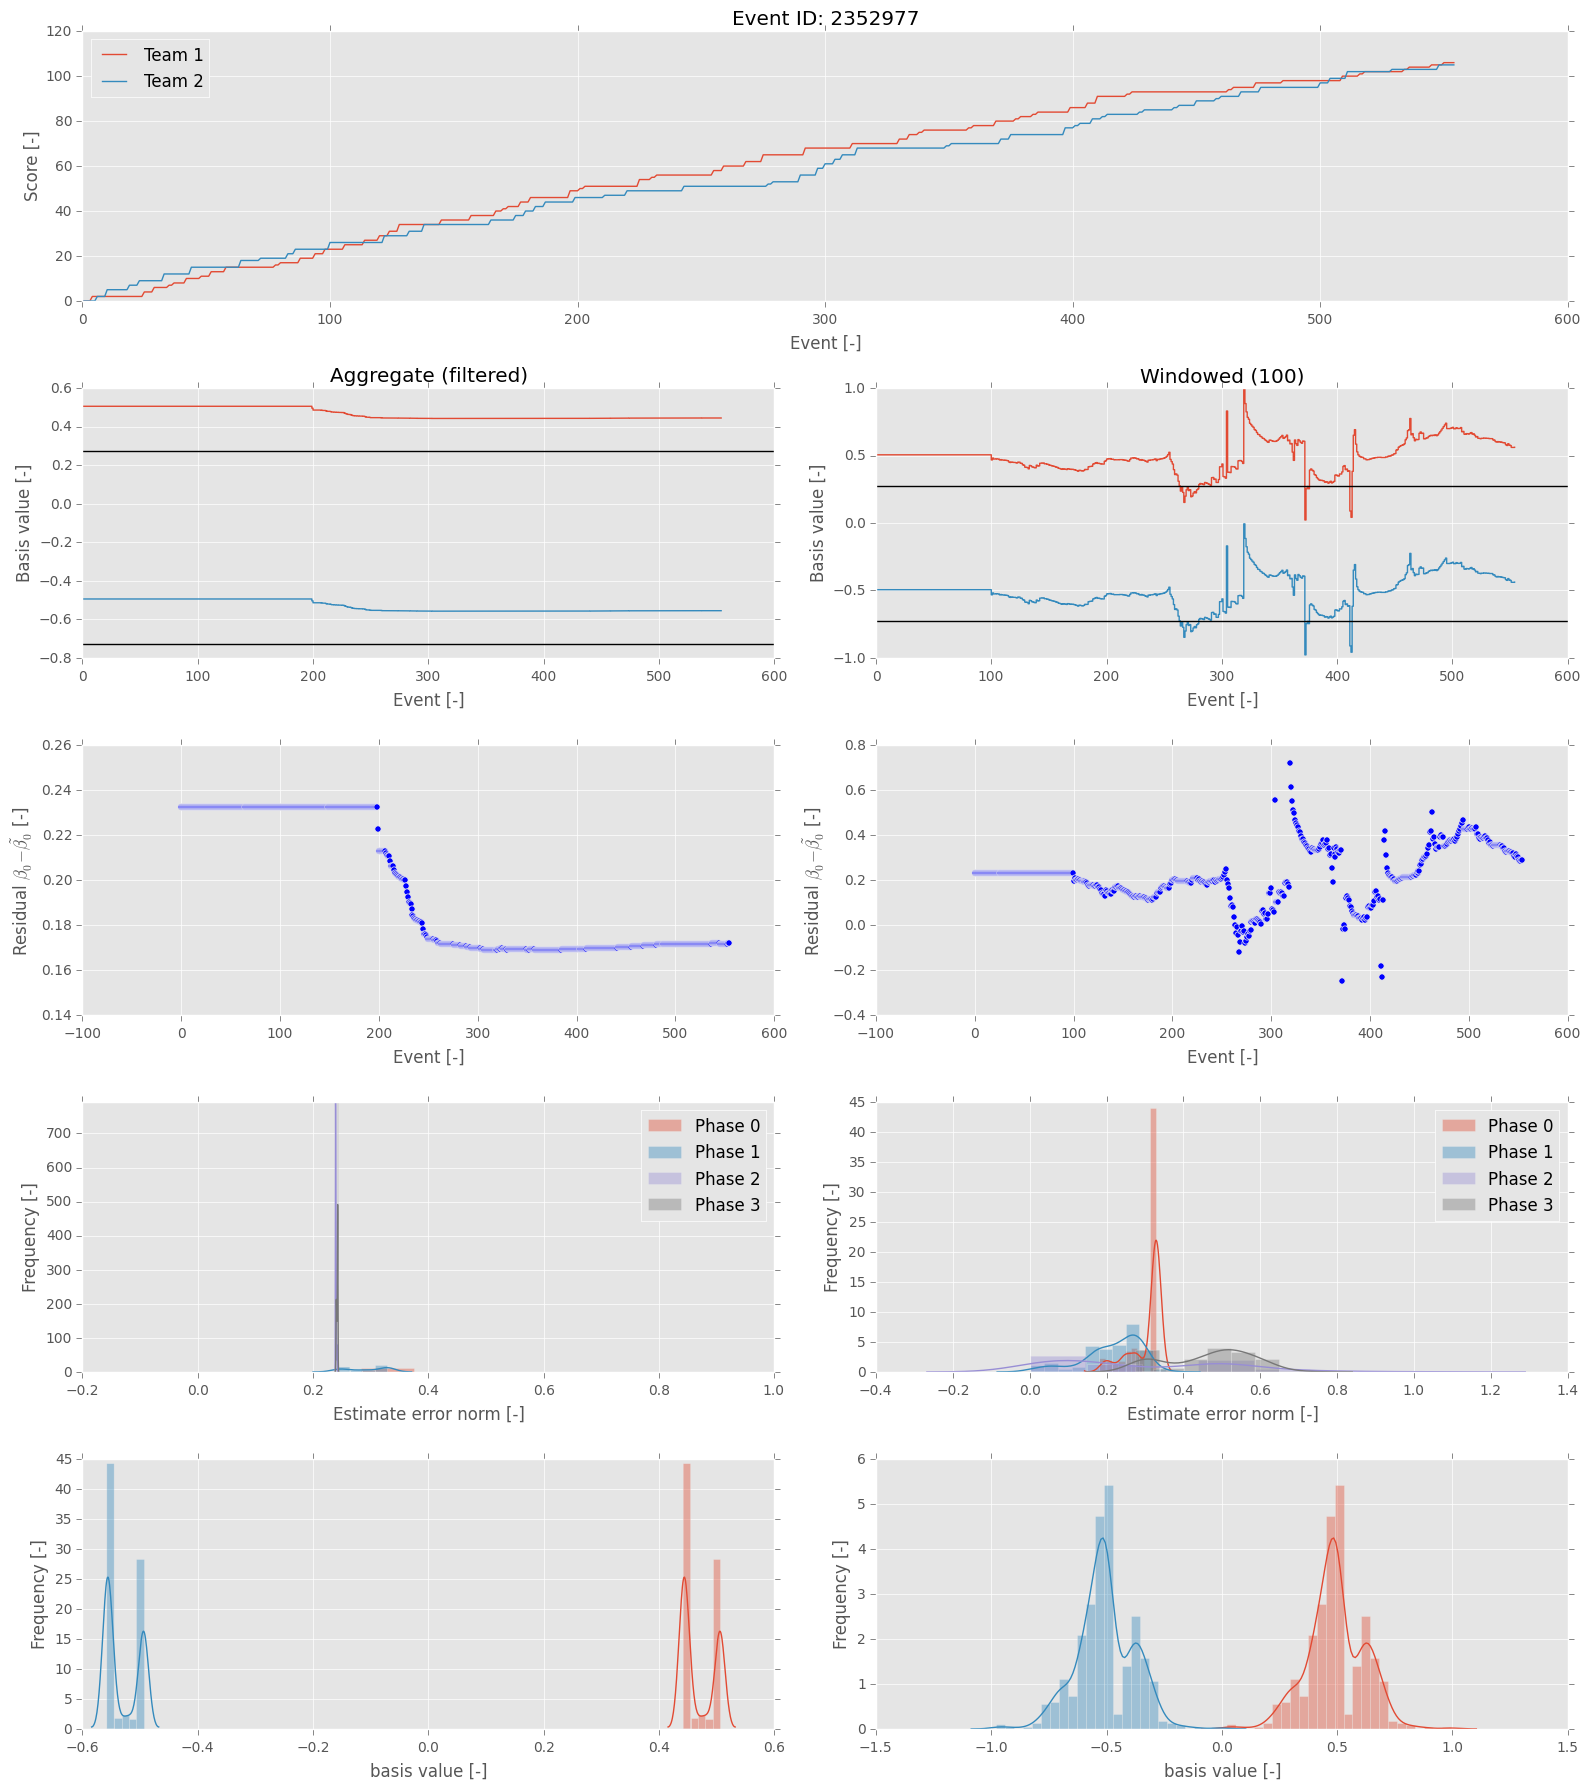

In [144]:
do_analysis(2352977)

First half:  [ 0.44381081 -0.55618919]
Second half: [ 0.46521175 -0.53478825]
Full match:  [ 0.43462184 -0.56537816]


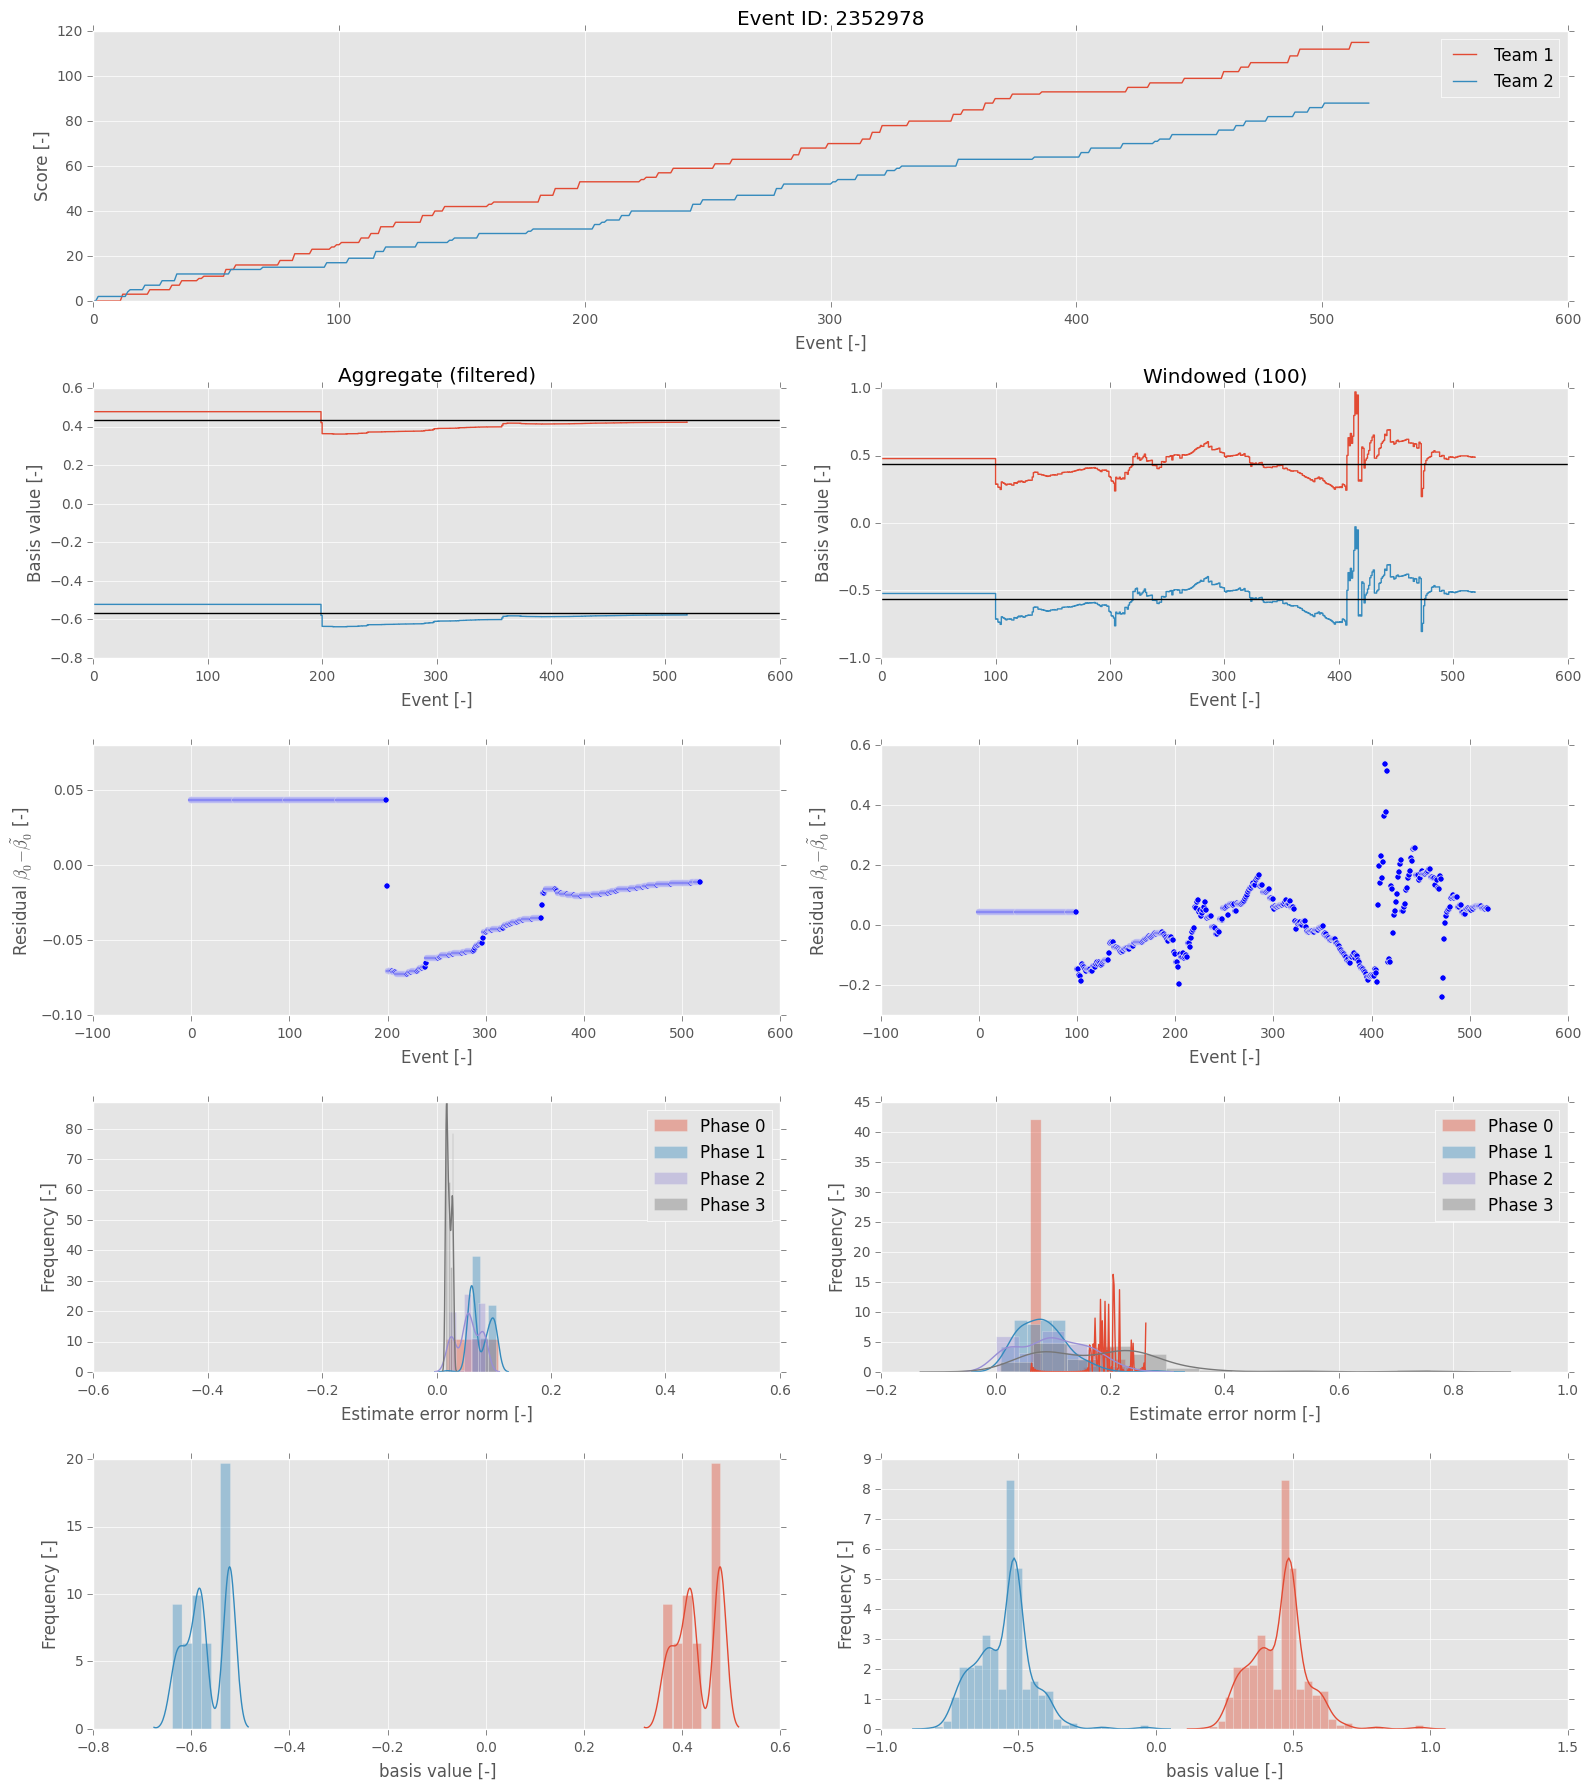

In [145]:
do_analysis(2352978)

First half:  [ 0.61379392 -0.38620608]
Second half: [ 0.37147995 -0.62852005]
Full match:  [ 0.55842196 -0.44157804]


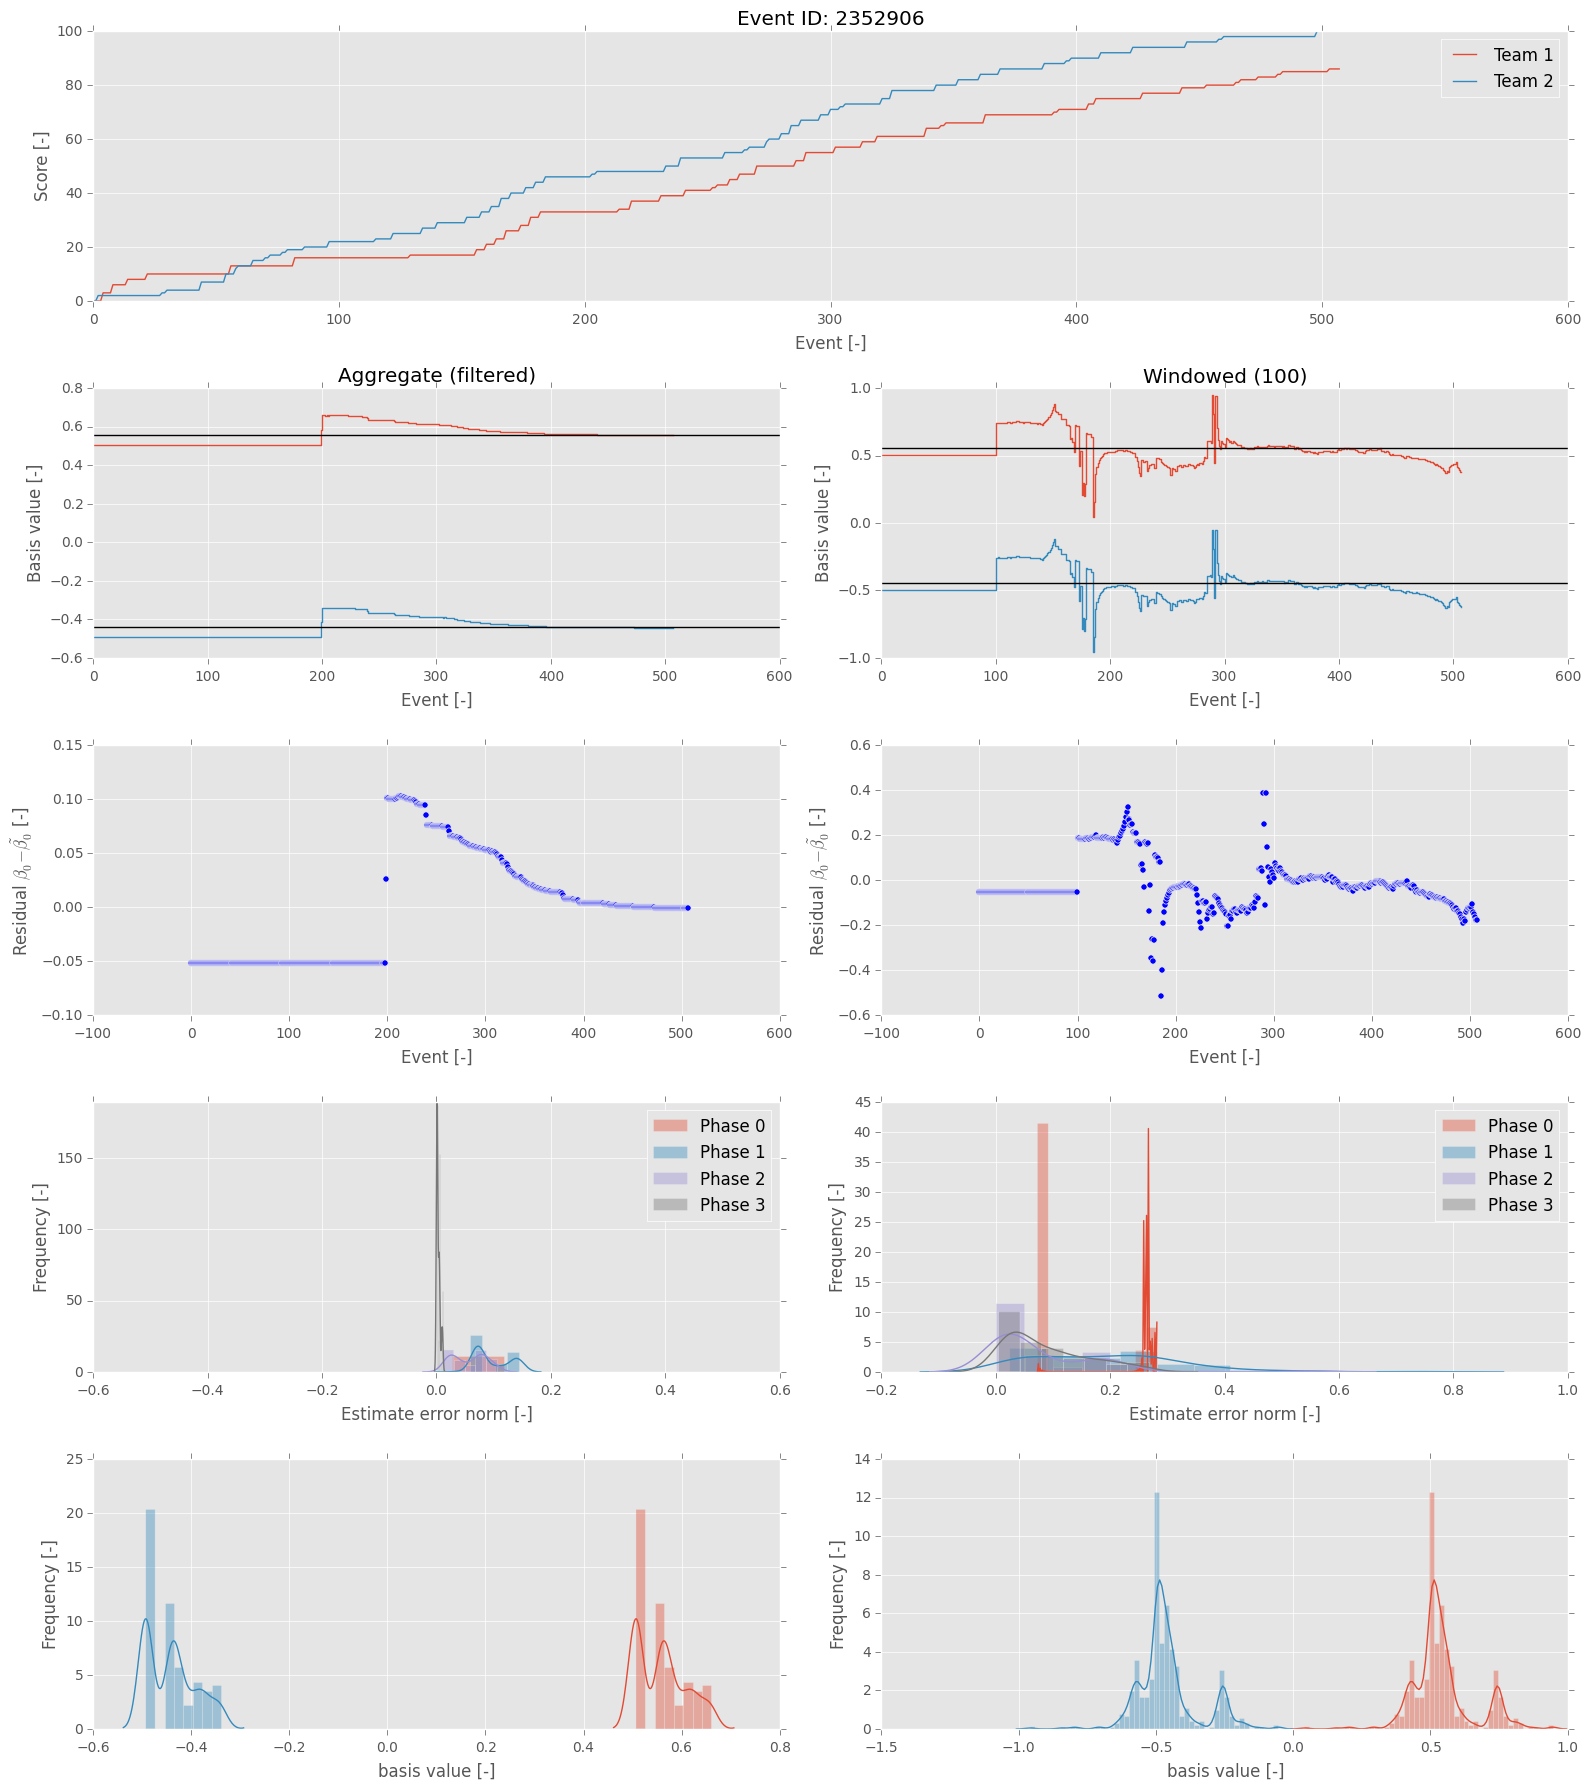

In [146]:
do_analysis(2352906)

First half:  [ 0.588706 -0.411294]
Second half: [ 0.57615884 -0.42384116]
Full match:  [ 0.55587143 -0.44412857]


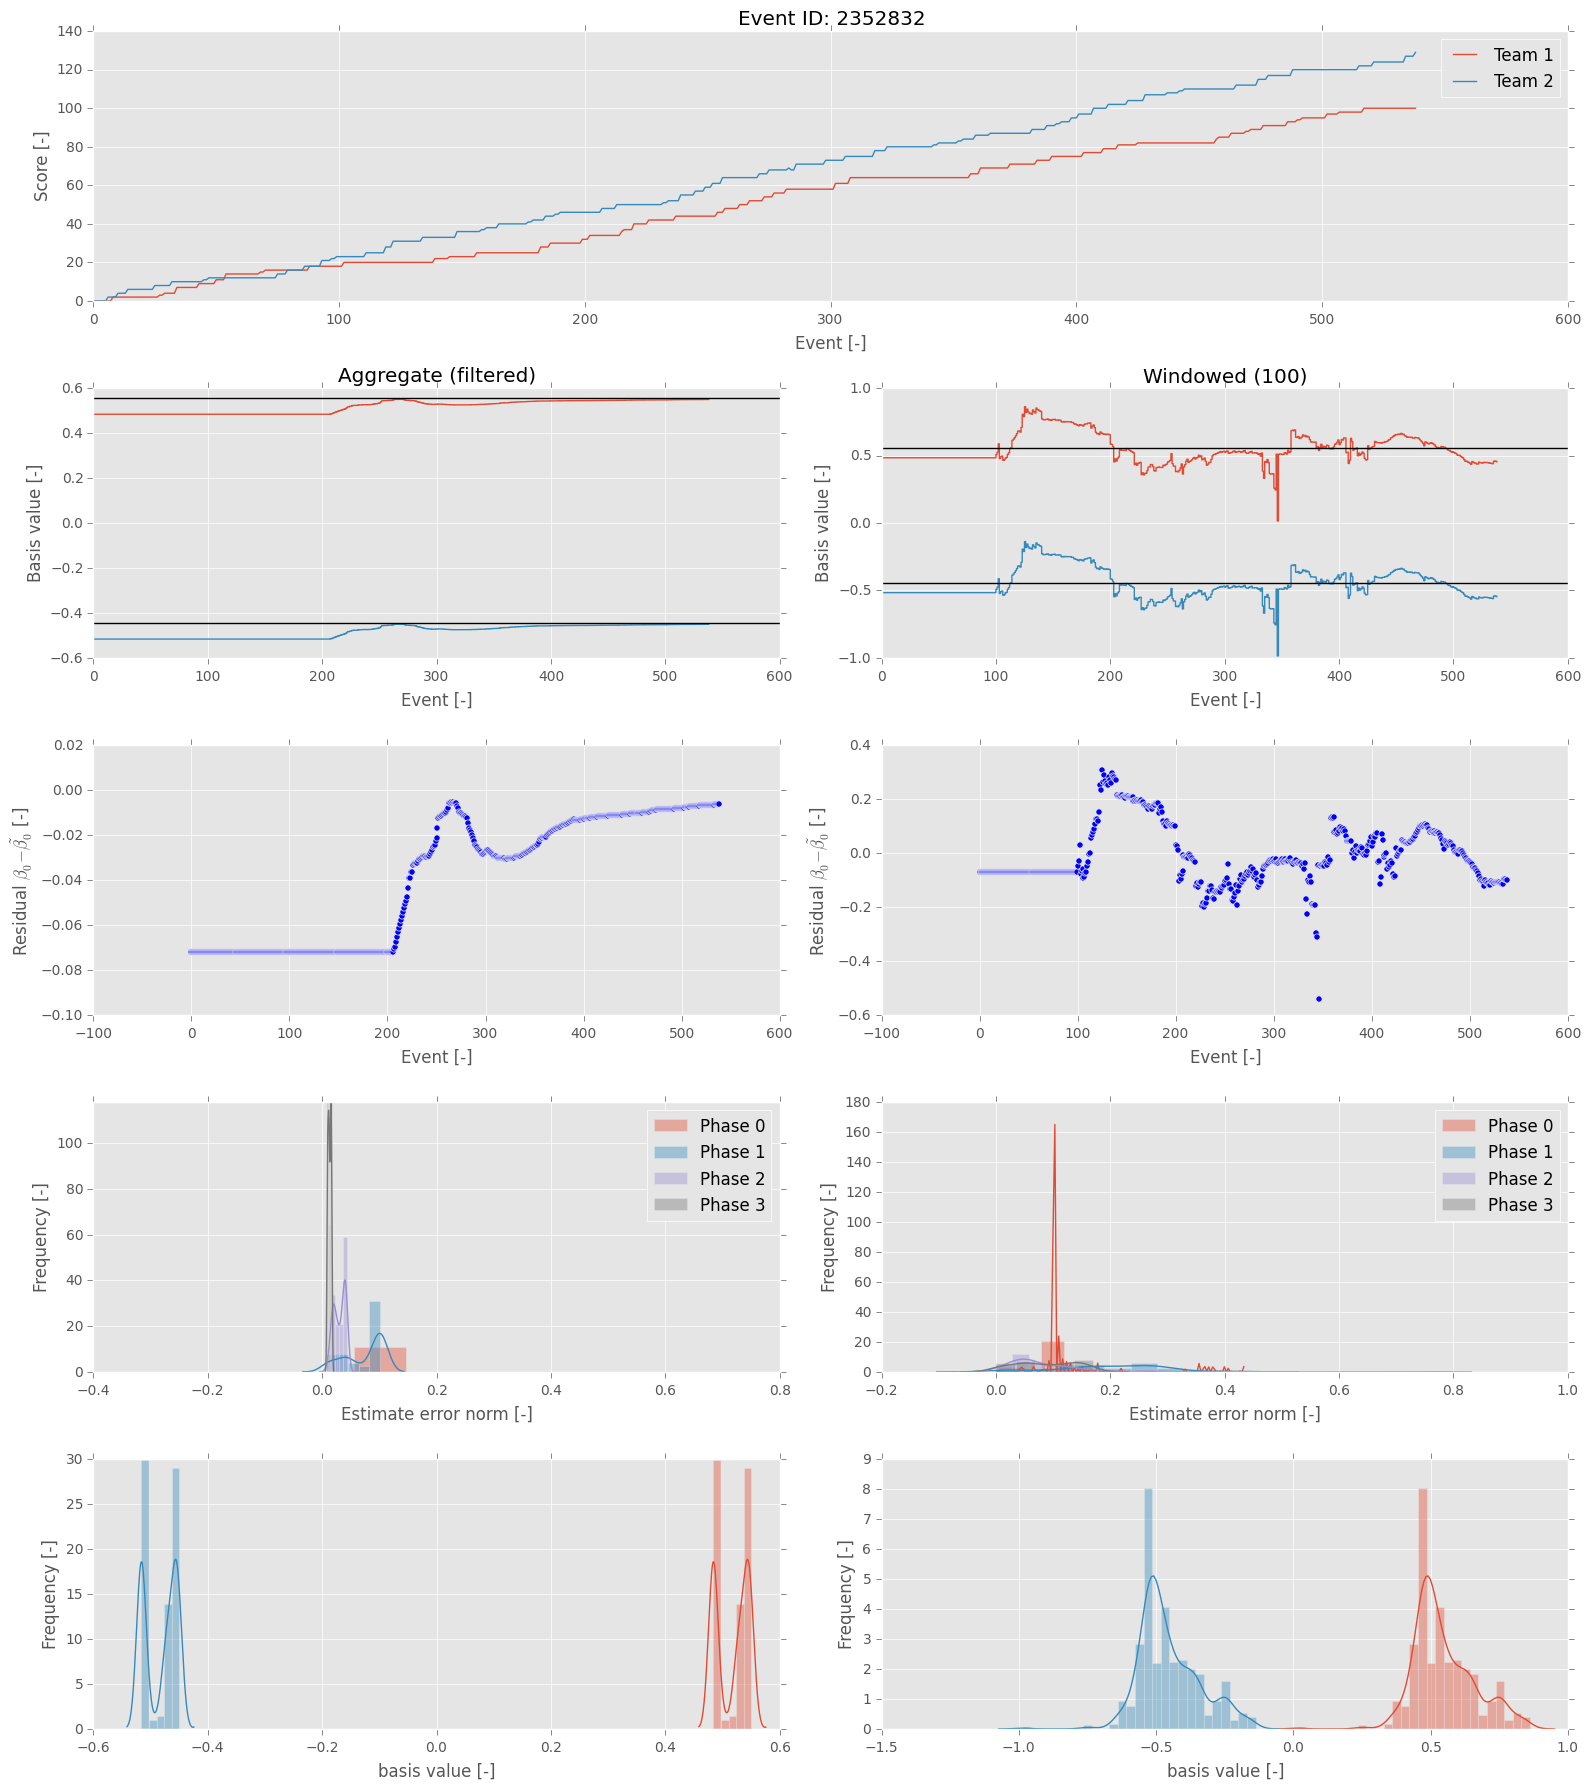

In [147]:
do_analysis(2352832)